# Fullscan Renders
Outputting the graphs of the data collected by running the robot :) This notebook is for viewing the fullscan data, as well as trying to reproduce a mathematical model of the relationship between the transducer pulser and it's position/rotation.

### Import relevant modules

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import json
import pandas as pd
import sys
import scipy
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

%matplotlib inline
# %matplotlib widget
# %pylab

from fit_funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check for available files

In [205]:
path = os.path.abspath('..\\')
print("Available test files:")

## Uncomment this to access immersion transducer scans
# file_itr = 0
# while os.path.exists(path + "\\Scans\\Immersion_Transducer_Scans\\test_%s.json" % file_itr):
#     print("\t\\Scans\\Immersion_Transducer_Scans\\test_%s.json" % file_itr)
#     file_itr +=1

file_itr = 0
while os.path.exists(path + "\\Scans\\OCE_Scans\\oce_test_%s.json" % file_itr):
    print("\t\\Scans\\OCE_Scans\\oce_test_%s.json" % file_itr)
    file_itr +=1


offsets = [mcolors.TwoSlopeNorm(vmin=-1.25,vcenter=0., vmax=1.25), 
            mcolors.Normalize(vmin=0, vmax=500)]

Available test files:
	\Scans\OCE_Scans\oce_test_0.json
	\Scans\OCE_Scans\oce_test_1.json
	\Scans\OCE_Scans\oce_test_2.json
	\Scans\OCE_Scans\oce_test_3.json
	\Scans\OCE_Scans\oce_test_4.json
	\Scans\OCE_Scans\oce_test_5.json
	\Scans\OCE_Scans\oce_test_6.json
	\Scans\OCE_Scans\oce_test_7.json
	\Scans\OCE_Scans\oce_test_8.json
	\Scans\OCE_Scans\oce_test_9.json
	\Scans\OCE_Scans\oce_test_10.json
	\Scans\OCE_Scans\oce_test_11.json
	\Scans\OCE_Scans\oce_test_12.json
	\Scans\OCE_Scans\oce_test_13.json


### Select appropriate file and output options
Debug mode prints more information to the notebook, save_figs outputs the relevant figures to a designated folder, and file_no specifices which scan file should be used.

In [206]:
debug_mode = True
save_figs = True
file_no = 13

# plt.style.use("dark_background")
plt.style.use("default")

if save_figs:
    plt.rcParams['figure.dpi'] = 400
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    })
    newpath = os.path.abspath('') + f"\\figures\\Scan_{file_no}"
    if not os.path.exists(newpath):
        os.makedirs(newpath)
else:
    plt.rcParams['figure.dpi'] = 250

In [207]:
# current_file = r"\Debugging Scripts\test_%s.json" % file_no
current_file = rf"\Scans\OCE_Scans\oce_test_{file_no}.json"
path = os.path.abspath('..\\') + current_file

if debug_mode:
    print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

print(json_data.keys())

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
points = json_data["points"]
max_point = json_data["max_point"]

if 'data_channels' in json_data.keys():
    num_channels = json_data['data_channels']
    data_labels = ['slope', 'intercept']
else:
    num_channels = 1

if debug_mode:
    for i in json_data.keys():
        if i != "points":
            print(f"{i}: {json_data[i]}")
        else:
            print(f"{i}: {json_data[i][0]}")


c:\Users\ander\OneDrive - UW\Robotics lab material\Robotics Control Code\Ben's Control Code\Scans\OCE_Scans\oce_test_13.json
dict_keys(['range of motion', 'resolution', 'scan_duration', 'notes', 'active_ROM', 'data_channels', 'max_point', 'points'])
range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-2.5, 2.5], 'Rx': [-5, 5], 'Ry': [-5, 5], 'Rz': [0, 0]}
resolution: [0.1, 0.88]
scan_duration: 00:15:40
notes: No notes passed from setup.
Ellipsoidal version of a fullscan module, scans an n-ellipse around the origin at a fixed resolution.
	Range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-2.5, 2.5], 'Rx': [-5, 5], 'Ry': [-5, 5], 'Rz': [0, 0]}
	Resolution: (0.1, 0.88)
	Highest magnitude found: [ 0.00  0.00 -1.30 -3.18 -2.27  0.00  1.72 -87.61]
active_ROM: ['Z', 'Rx', 'Ry']
data_channels: 2
max_point: [0.0, 0.0, -1.2999999999999998, -3.1818181818181817, -2.272727272727273, 0.0, 1.71878, -87.61211]
points: [-0.7, -1.3636363636363638, -5.0, 0.02592, 96.20365]


### Parse data into a pandas DataFrame

In [231]:
np_all = np.array(points)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
for i in range(num_channels):
    cols.append(data_labels[i])
dat = pd.DataFrame(data = np_all, columns=cols)

# mp = dat.loc[dat[data_labels].idxmax()].reset_index(drop=True)
# mp = dat.loc[abs(dat[data_labels[0]]*200 + dat[data_labels[1]] - 150) <= 1]#.reset_index(drop=True)
mp = dat.loc[abs(dat[data_labels[0]]*200 + dat[data_labels[1]] - 150) <= 2]#.reset_index(drop=True)
# mp = dat.loc[1798] # Best for Scan 13

if debug_mode:
    print(mp)
    print(mp.to_string())
    print(dat.head())
    print(dat.shape)

        Z        Rx        Ry    slope  intercept
8     0.1 -1.363636 -5.000000 -0.12629  173.80169
10    0.3 -1.363636 -5.000000 -0.18789  186.87444
46   -0.1  0.454545 -5.000000 -0.60014  269.18722
101  -0.4 -2.272727 -4.090909  0.50139   47.92782
179   1.0 -0.454545 -4.090909  0.30586   88.88436
373   0.8 -2.272727 -3.181818  0.25367  100.66071
633   0.5  4.090909 -3.181818  0.25503  100.91226
688   0.6 -3.181818 -2.272727  0.19028  113.47154
903  -0.9  1.363636 -2.272727  0.13399  122.02211
1117  0.4 -3.181818 -1.363636  0.12785  123.65639
1181 -2.5 -1.363636 -1.363636 -0.11258  173.42079
1210  0.4 -1.363636 -1.363636  0.12131  127.23429
1260  0.3 -0.454545 -1.363636  0.11656  128.15316
1292 -1.6  0.454545 -1.363636  0.36460   77.76820
1333  2.5  0.454545 -1.363636 -0.05264  159.28214
1392 -1.6  2.272727 -1.363636 -0.76583  304.51301
1564  0.3 -4.090909 -0.454545  0.04871  138.68620
1603  0.3 -3.181818 -0.454545  0.05271  138.66880
1647  0.1 -2.272727 -0.454545  0.07540  133.60955


(array([  1.,   0.,   0.,   0.,   0.,   1.,   2.,   2.,   0.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   1.,   3.,   3.,
          7.,   3.,   2.,   2.,   2.,   2.,   2.,   0.,   1.,   3.,   1.,
          1.,   0.,   1.,   2.,   2.,   1.,   6.,  15.,  23.,  47.,  44.,
         68.,  94.,  59., 232., 201.,  40.,  48.,  46.,  41.,  56.,  58.,
         44.,  44.,  44.,  34.,  53.,  48.,  48.,  39.,  34.,  35.,  50.,
         43.,  35.,  56.,  41.,  24.,  43.,  35.,  44.,  37.,  37.,  40.,
         40.,  34.,  31.,  35.,  44.,  45.,  34.,  32.,  32.,  39.,  35.,
         46.,  39.,  43.,  34.,  31.,  35.,  47.,  30.,  42.,  35.,  44.,
         20.,  29.,  34.,  34.,  34.,  20.,  37.,  26.,  33.,  29.,  24.,
         35.,  25.,  25.,  28.,  23.,  21.,  10.,  29.,  26.,  25.,  19.,
         27.,  15.,  16.,  17.,  17.,  20.,  18.,  11.,  18.,  13.,  18.,
          9.,  11.,  18.,  23.,  15.,   7.,  23.,  16.,  15.,  10.,  16.,
         10.,   9.,   9.,  16.,  11., 

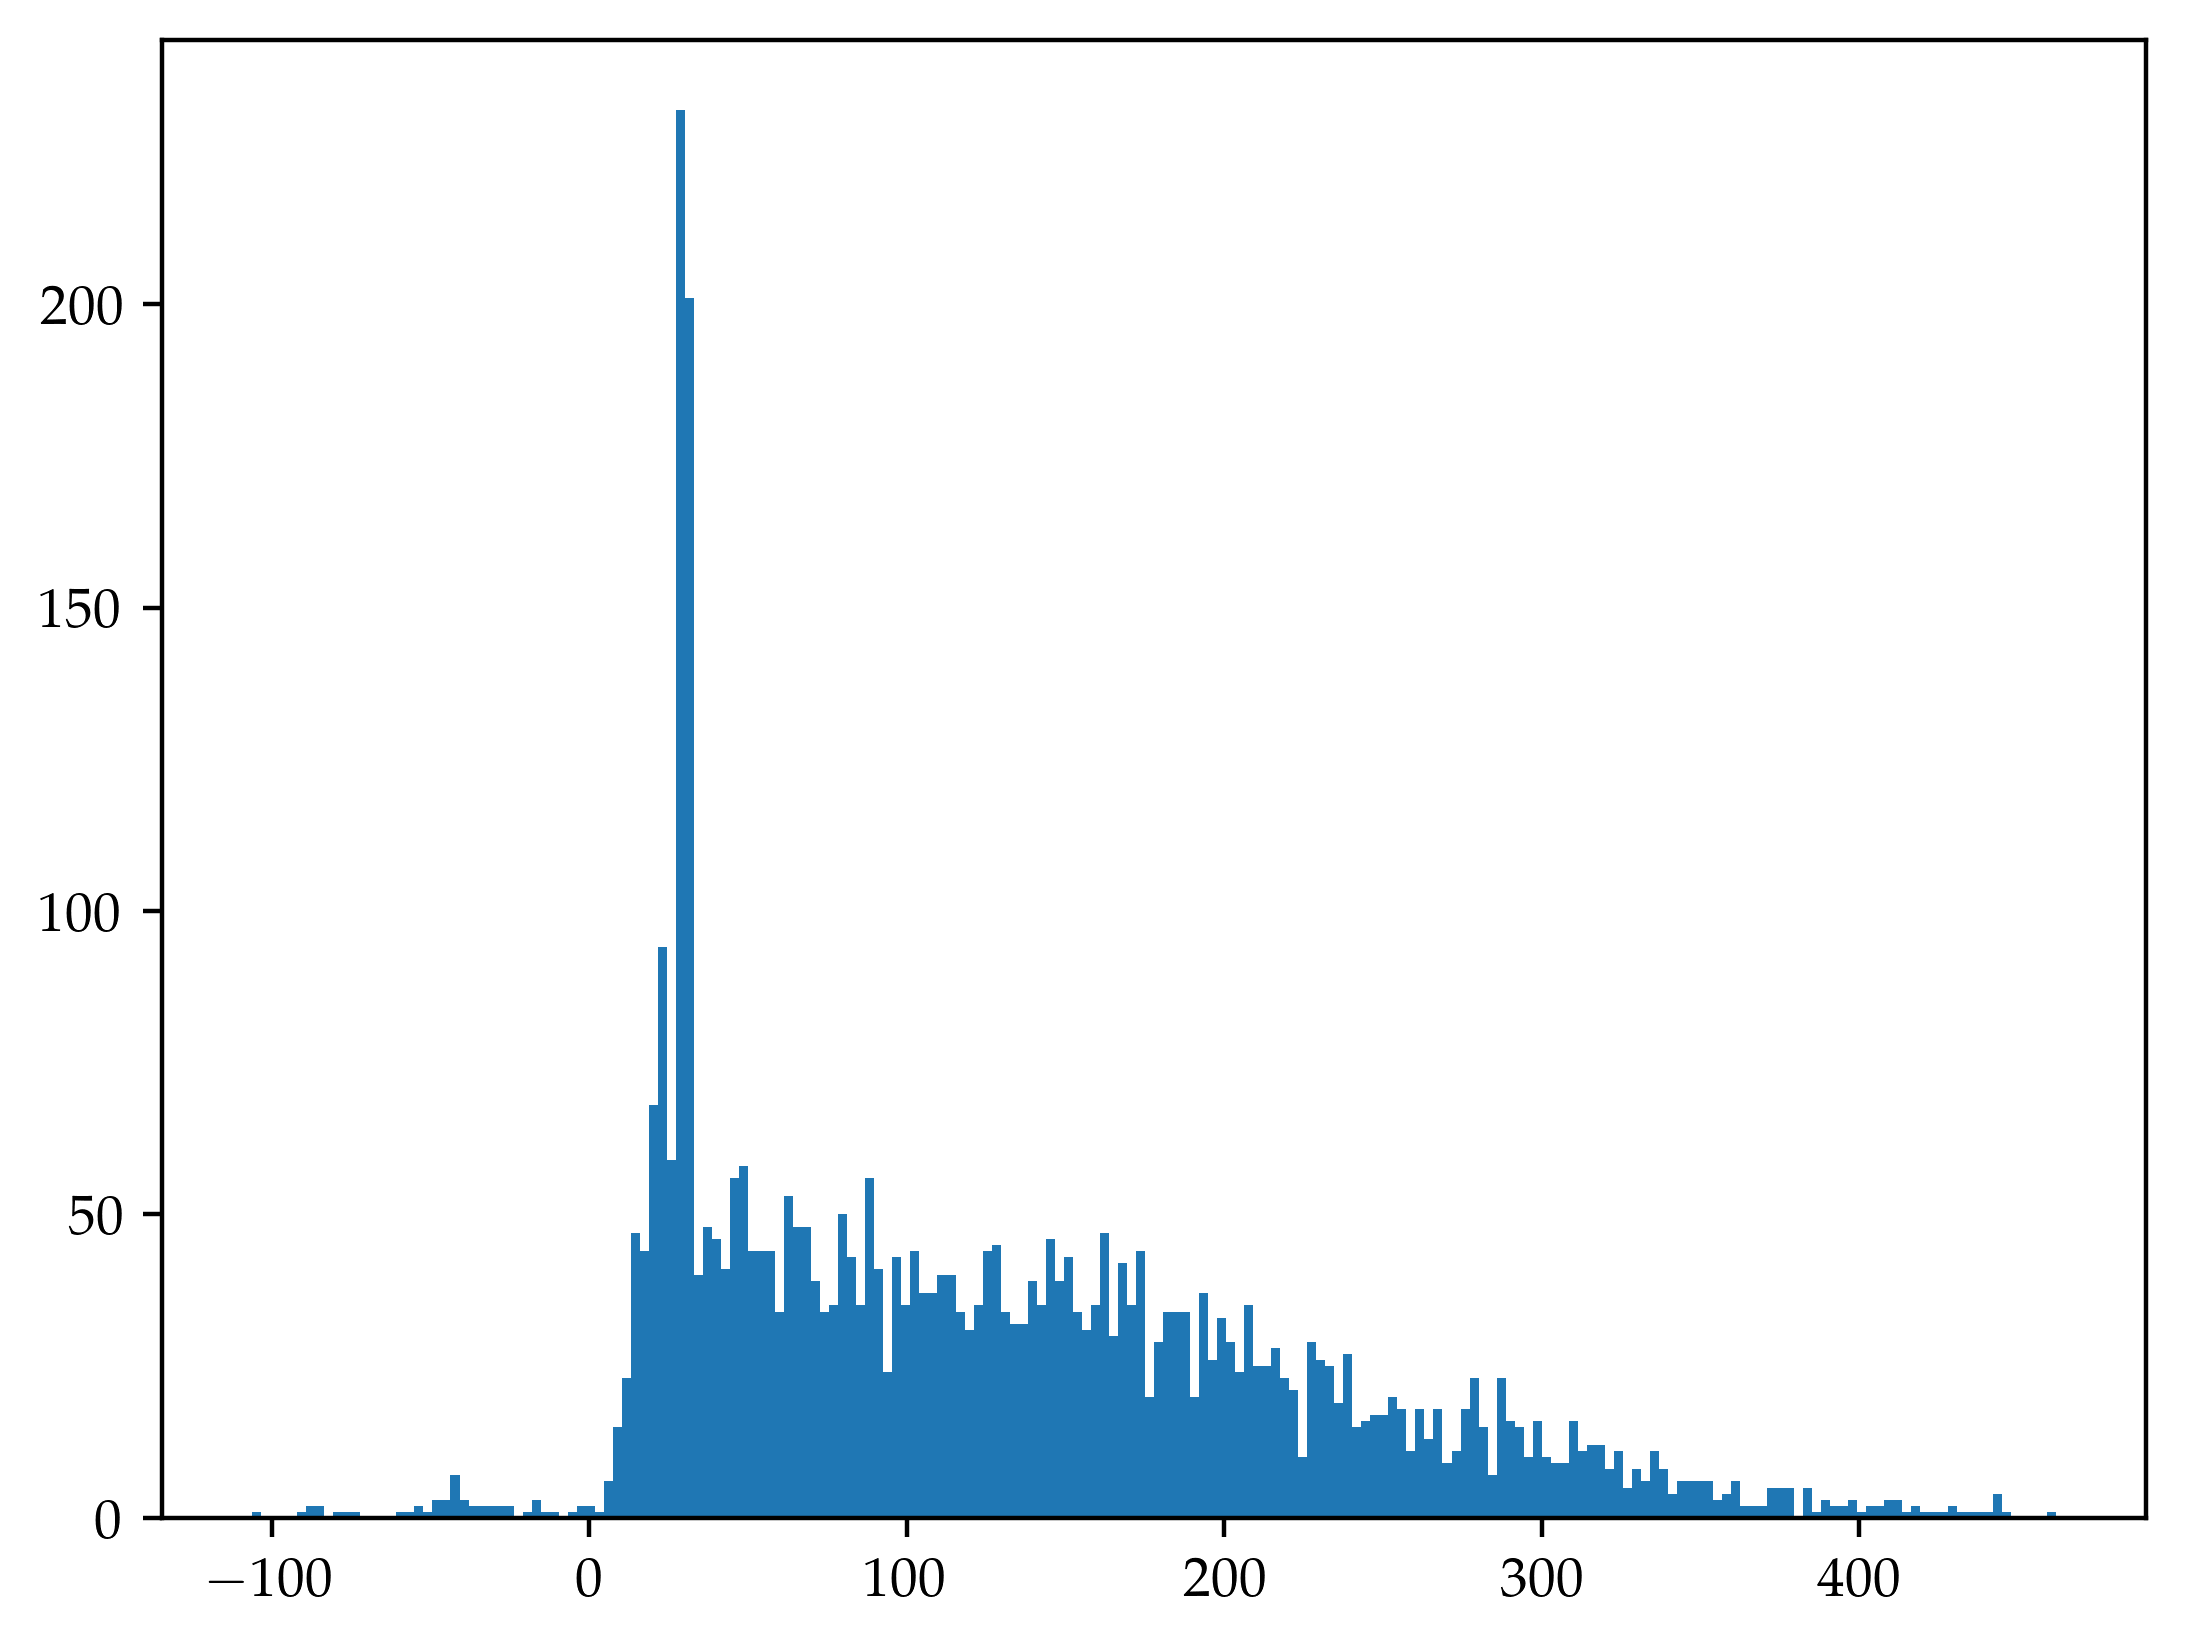

In [209]:
i=1
counts,bins = np.histogram(dat[data_labels[i]],200)

# plt.stairs(counts,bins)
plt.hist(bins[:-1],bins,weights=counts)

### First Figure, all data

[0.00014, 0]
19875
20235
Maximum magnitude:  1.71878
Minimum magnitude: -1.29845
Median magnitude: [0.00014, 0]
1.71878
[0.00014, 111.82207]
20235
20235
Maximum magnitude:  462.03511
Minimum magnitude: -106.32188
Median magnitude: [0.00014, 111.82207]
462.03511


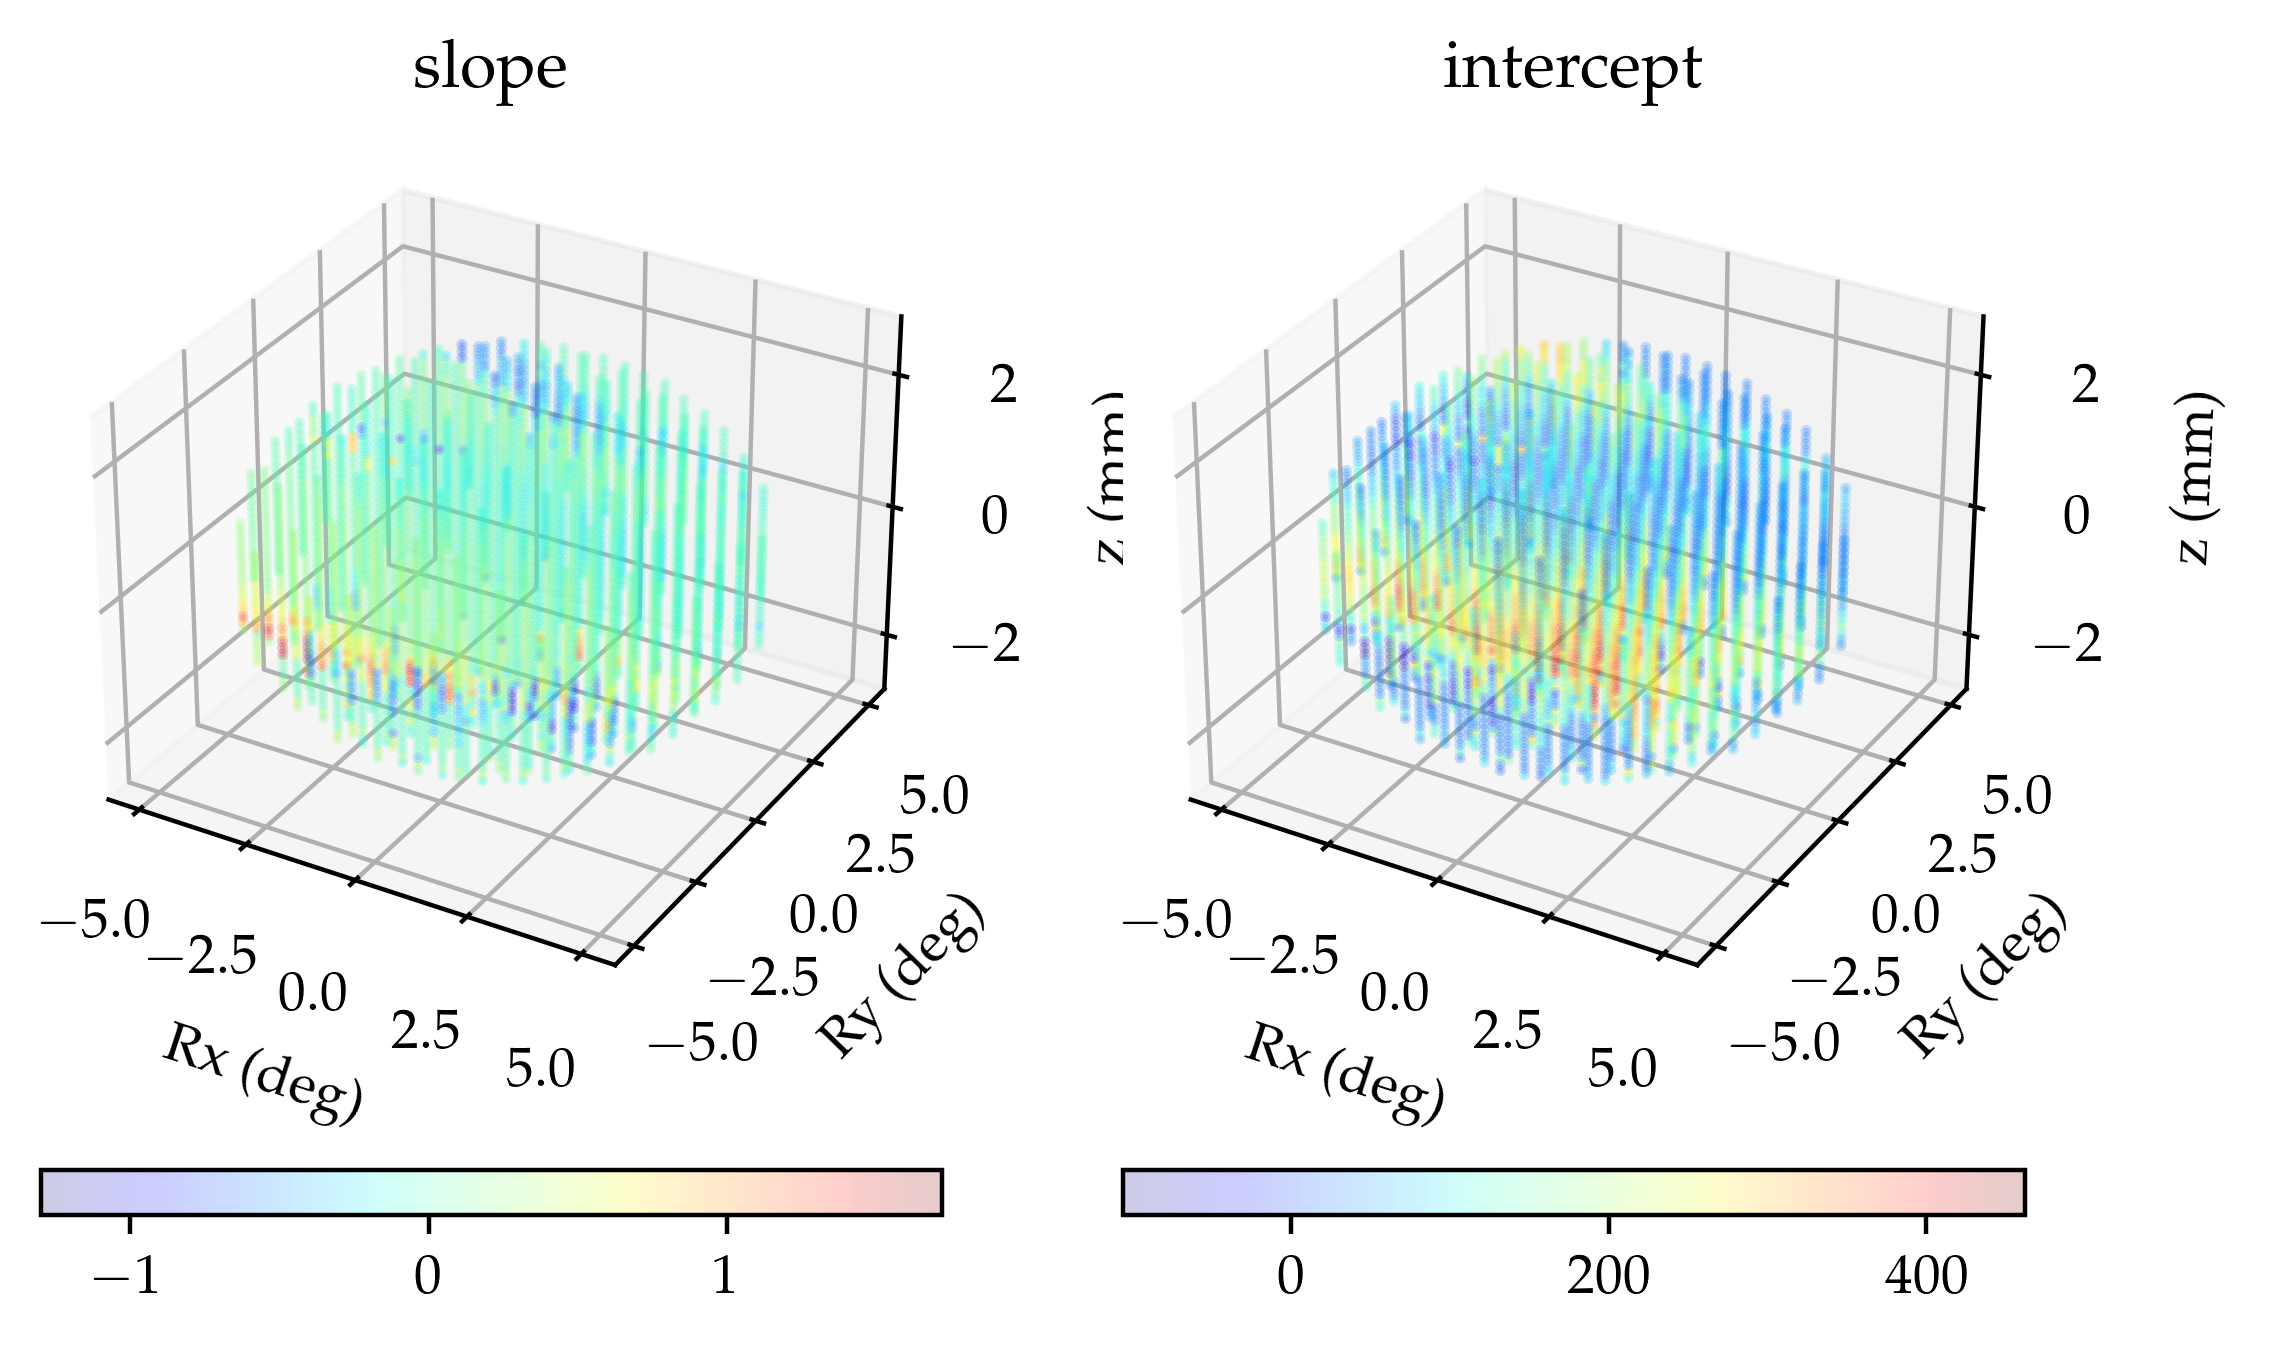

In [210]:
fig = plt.figure()
med = [0,0]

for i in range(num_channels):
    ax = fig.add_subplot(1,num_channels,i+1,projection='3d')
    # ax = plt.axes(projection='3d')
    data_col = data_labels[i]

    med[i] = np.median(dat[data_col])

    if i == 0:
        dat2 = dat[dat[data_col] != 0]
    else:
        dat2 = dat[dat[data_col] != -1]
        dat2 = dat2[dat2[data_col] != 0]

    # dat_saturate = dat[dat[data_col] == -1]

    print(med)
    print(dat2.size)
    print(dat.size)

    cmap = plt.cm.viridis # Choose colormap
    my_cmap = cmap(np.arange(cmap.N)) # Get the colormap colors
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)*0.8 # Set alpha
    my_cmap = ListedColormap(my_cmap) # Create new colormap

    # scatterplot = ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2[data_col], cmap='jet', alpha=0.4,s=1)
    # ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat[data_col], cmap=my_cmap,s=4)
    scatterplot = ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat[data_col], cmap='jet',s=1,alpha=0.2)

    plt.colorbar(scatterplot, orientation='horizontal', pad=0.1)


    ax.set_title(f"{data_col}")
    ax.set_xlabel("Rx (deg)")
    ax.set_ylabel("Ry (deg)")
    ax.set_zlabel("z (mm)")

    if save_figs:
        plt.savefig(f"figures\\Scan_{file_no}\\fullscan_render_test.jpg")
        pass
    
    # plt.show()

    if debug_mode:
        print(f"Maximum magnitude:  {max(dat[data_col])}")
        print(f"Minimum magnitude: {min(dat[data_col])}")
        print(f"Median magnitude: {med}")
        print(max(dat[data_col]))
    
        # print((min(dat2['Rx']),max(dat2['Rx'])))
        # print((min(dat2['Ry']),max(dat2['Ry'])))
        # print((min(dat2['Z']),max(dat2['Z'])))

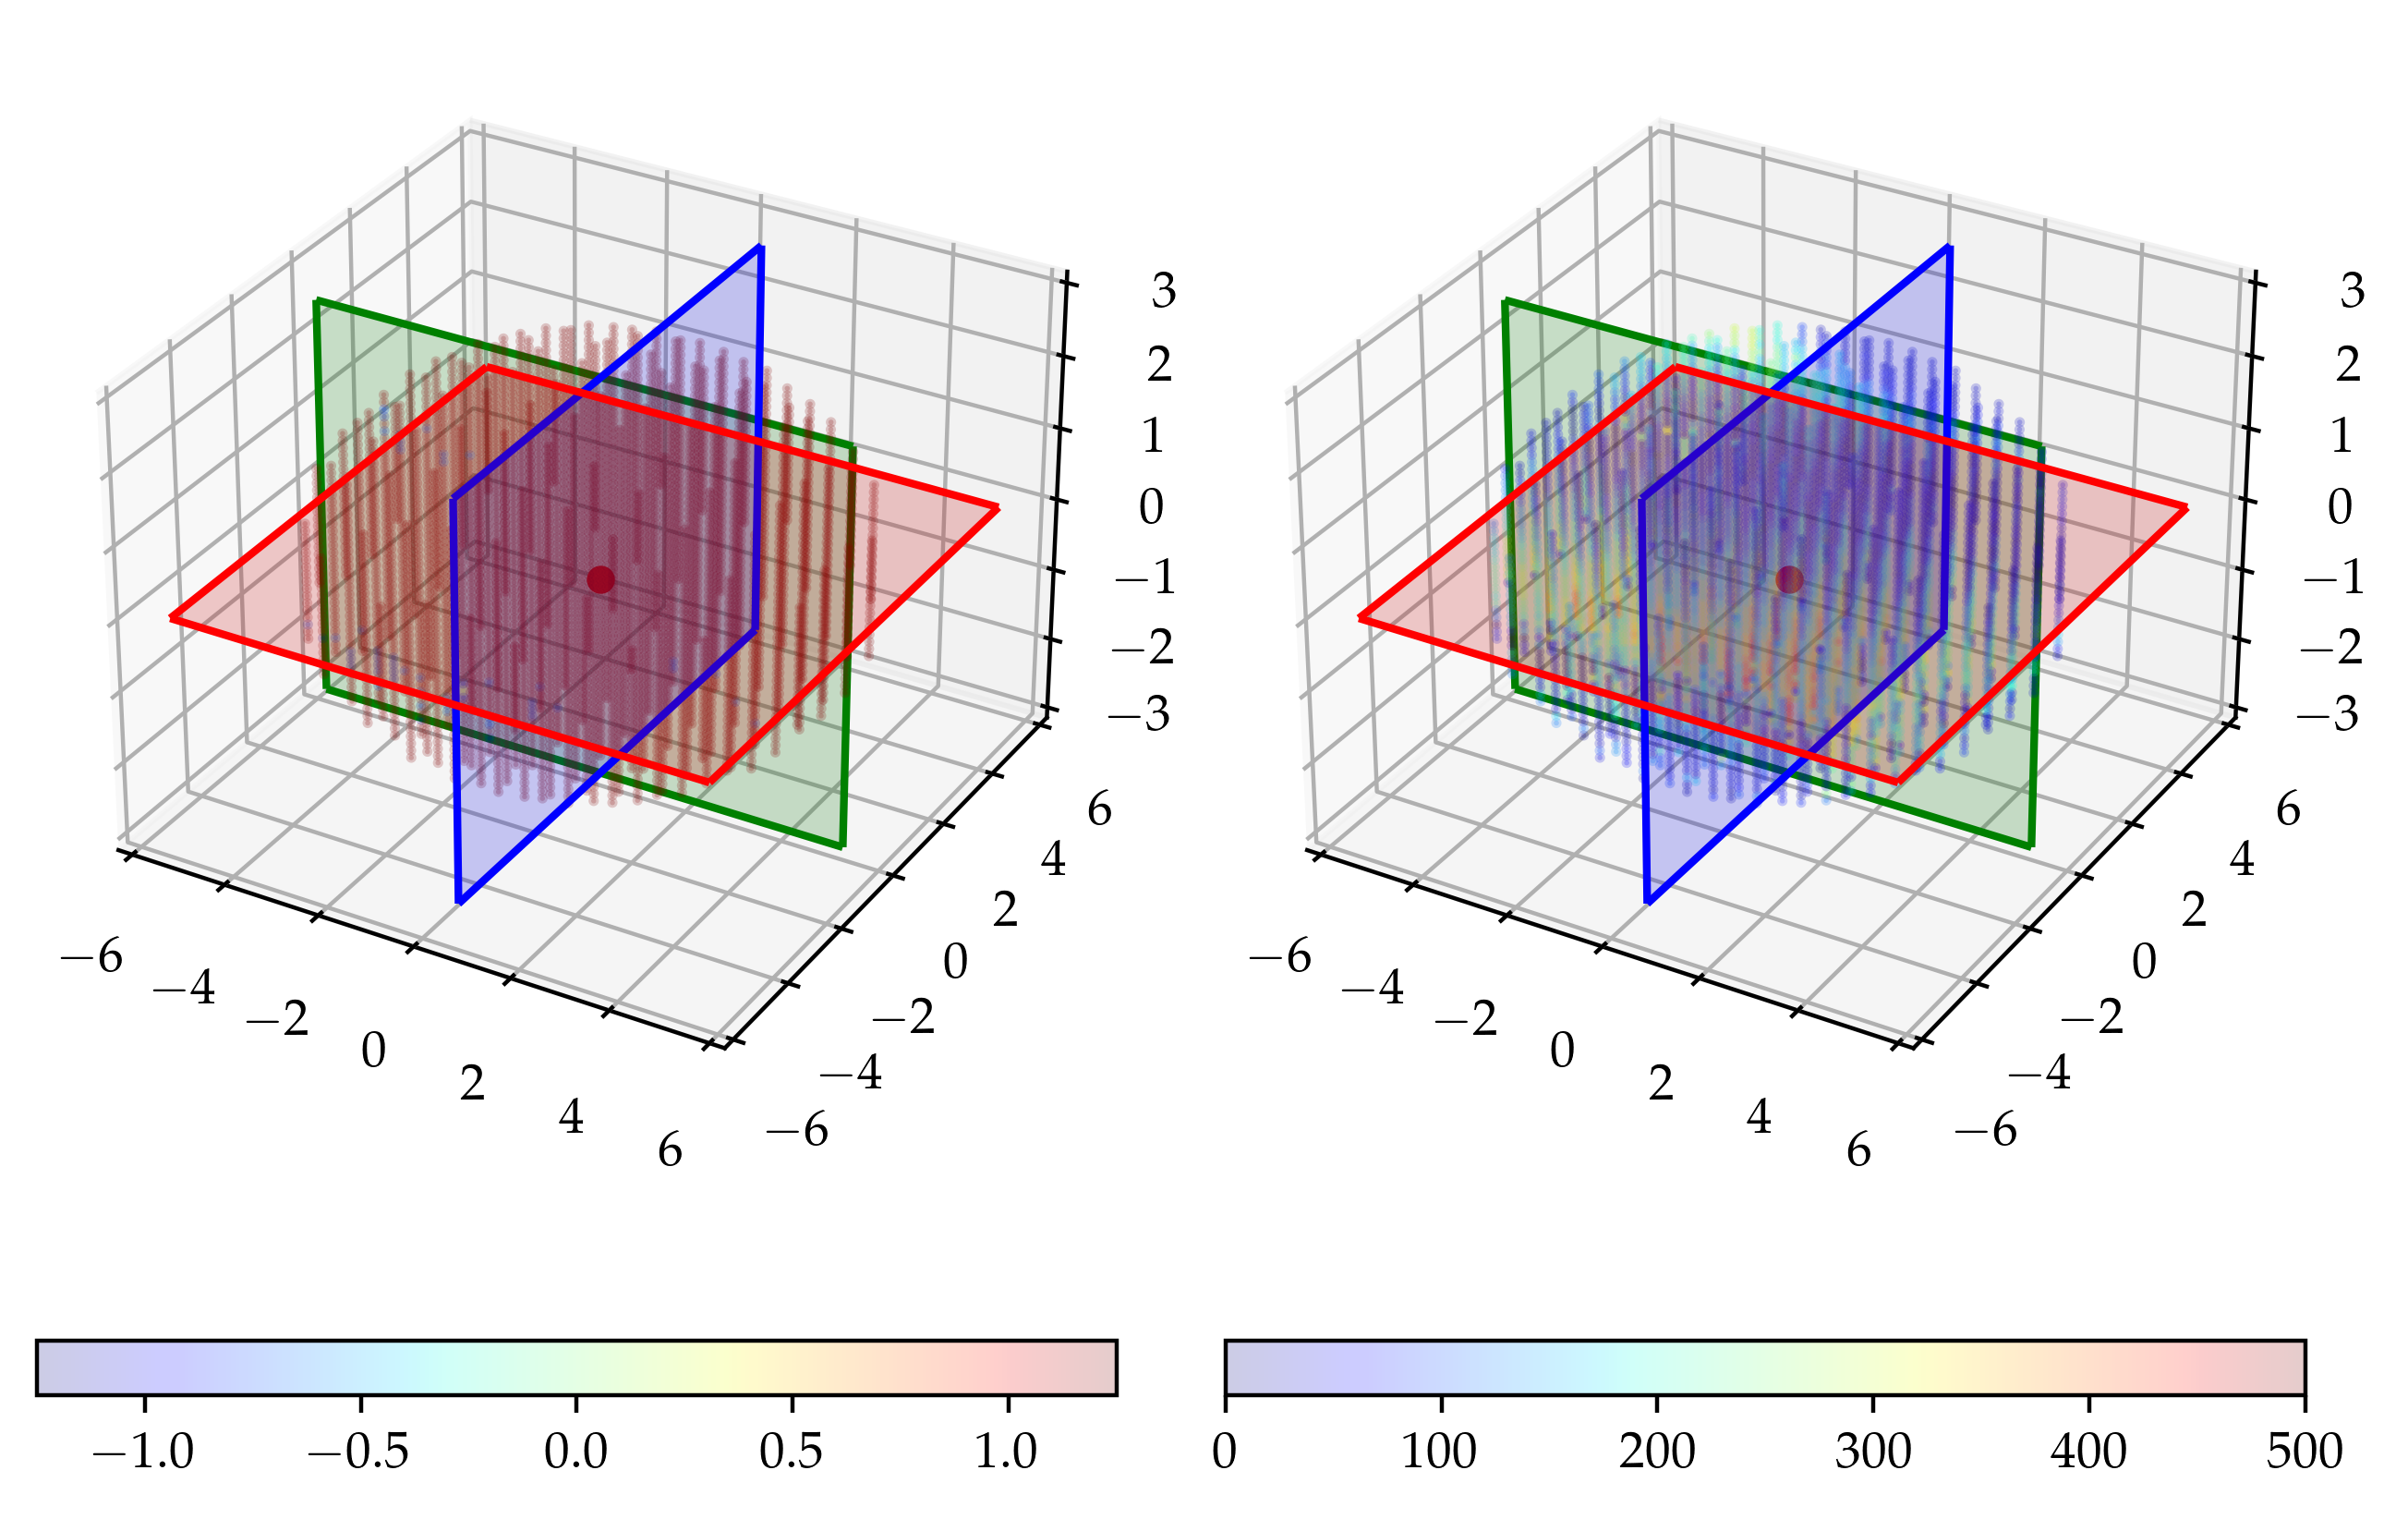

In [211]:
fig = plt.figure(constrained_layout=True)
alpha = 0.2

for i in range(num_channels):
    ax = fig.add_subplot(1,num_channels,i+1,projection='3d')
# ax = fig.add_subplot(projection='3d')

    scatter = ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat[data_col],
        cmap='jet',s=1,alpha=alpha,norm=offsets[i])
    # ax.scatter(mp.loc[i]['Rx'], mp.loc[i]['Ry'], mp.loc[i]['Z'], color='r')
    ax.scatter(mp.loc['Rx'], mp.loc['Ry'], mp.loc['Z'], color='r')
    plt.colorbar(scatter, orientation='horizontal', pad=0.1)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()

    X,Y = np.meshgrid(xlim,ylim)
    # Z = np.ones(X.shape)*mp.loc[i]['Z']
    Z = np.ones(X.shape)*mp.loc['Z']
    ax.plot_surface(X=X, Y=Y, Z=Z, color='r', alpha=alpha)
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='r')

    # Slice through the Rx-Z plane with maximum Ry
    X,Z = np.meshgrid(xlim,zlim)
    # Y = np.ones(Y.shape)*mp.loc[i]['Ry']
    Y = np.ones(Y.shape)*mp.loc['Ry']
    ax.plot_surface(X=X, Y=Y, Z=Z, color='g', alpha=alpha)
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='g')

    # Slice through the Rx-Ry plane with maximum Z
    Z,Y = np.meshgrid(zlim,ylim)
    # X = np.ones(X.shape)*mp.loc[i]['Rx']
    X = np.ones(X.shape)*mp.loc['Rx']
    ax.plot_surface(X=X, Y=Y, Z=Z, color='b', alpha=alpha)
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='b')


if save_figs:
    plt.savefig(f"figures\\Scan_{file_no}\\data_slice1.jpg", dpi=400)

In [212]:
# "mps" stands for "max points," or all the points in Rx/Ry space that occur at the max
# value of Z, rotated for each of the other dimensions
# mp = max_point[0]

(zmps,Rxmps,Rymps,z_isolated_mps,Rx_isolated_mps,Ry_isolated_mps) = ([0,0],[0,0],[0,0],[0,0],[0,0],[0,0])

for i in range(num_channels):
    # zmps[i] = dat[dat['Z'] == mp.loc[i]['Z']].copy()
    # Rxmps[i] = dat[dat['Rx'] == mp.loc[i]['Rx']].copy()
    # Rymps[i] = dat[dat['Ry'] == mp.loc[i]['Ry']].copy()
    zmps[i] = dat[dat['Z'] == mp.loc['Z']].copy()
    Rxmps[i] = dat[dat['Rx'] == mp.loc['Rx']].copy()
    Rymps[i] = dat[dat['Ry'] == mp.loc['Ry']].copy()
    med[i] = np.median(dat[data_labels[i]])

    # foo_isolated_mps refers to the points along the isolated foo axis when the other axes are at their optimal values
    # z_isolated_mps[i] = dat[np.all([dat['Rx'] == mp['Rx'].loc[i], dat['Ry'] == mp.loc[i]['Ry']],axis=0)].reset_index(drop=True)
    # Rx_isolated_mps[i] = dat[np.all([dat['Z'] == mp['Z'].loc[i], dat['Ry'] == mp.loc[i]['Ry']],axis=0)].reset_index(drop=True)
    # Ry_isolated_mps[i] = dat[np.all([dat['Z'] == mp['Z'].loc[i], dat['Rx'] == mp.loc[i]['Rx']],axis=0)].reset_index(drop=True)
    z_isolated_mps[i] = dat[np.all([dat['Rx'] == mp['Rx'], dat['Ry'] == mp['Ry']],axis=0)].reset_index(drop=True)
    Rx_isolated_mps[i] = dat[np.all([dat['Z'] == mp['Z'], dat['Ry'] == mp['Ry']],axis=0)].reset_index(drop=True)
    Ry_isolated_mps[i] = dat[np.all([dat['Z'] == mp['Z'], dat['Rx'] == mp['Rx']],axis=0)].reset_index(drop=True)


if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(f"Shape of point/mags array: {np_all.shape}")
    print(f"Tenth point_mag item (representative): {np_all[10]}")
    print(f"Testing the Z-max-points array:\n{zmps[i].head(4)}\n(Should be all the same as in the maxpoint)")
    print(f"Maximum point: {mp}")
    print(Ry_isolated_mps)
    # print(Rx_isolated_mps)
    # print(Ry_isolated_mps)
    


Active range of motion: ['Z', 'Rx', 'Ry']
Shape of point/mags array: (4047, 5)
Tenth point_mag item (representative): [  0.3         -1.36363636  -5.          -0.18789    186.87444   ]
Testing the Z-max-points array:
      Z        Rx   Ry    slope  intercept
7   0.0 -1.363636 -5.0 -0.41967  187.01823
26  0.0 -0.454545 -5.0  0.31719  175.77861
47  0.0  0.454545 -5.0 -0.39620  276.34868
66  0.0  1.363636 -5.0 -0.13698  195.76538
(Should be all the same as in the maxpoint)
Maximum point: Z              0.000000
Rx             0.454545
Ry            -0.454545
slope          0.051070
intercept    139.645900
Name: 1798, dtype: float64
[      Z        Rx        Ry    slope  intercept
0   0.0  0.454545 -5.000000 -0.39620  276.34868
1   0.0  0.454545 -4.090909  0.29727  223.58549
2   0.0  0.454545 -3.181818  0.22979  207.20192
3   0.0  0.454545 -2.272727  0.18330  183.78917
4   0.0  0.454545 -1.363636  0.10744  161.68598
5   0.0  0.454545 -0.454545  0.05107  139.64590
6   0.0  0.454545  0.4545

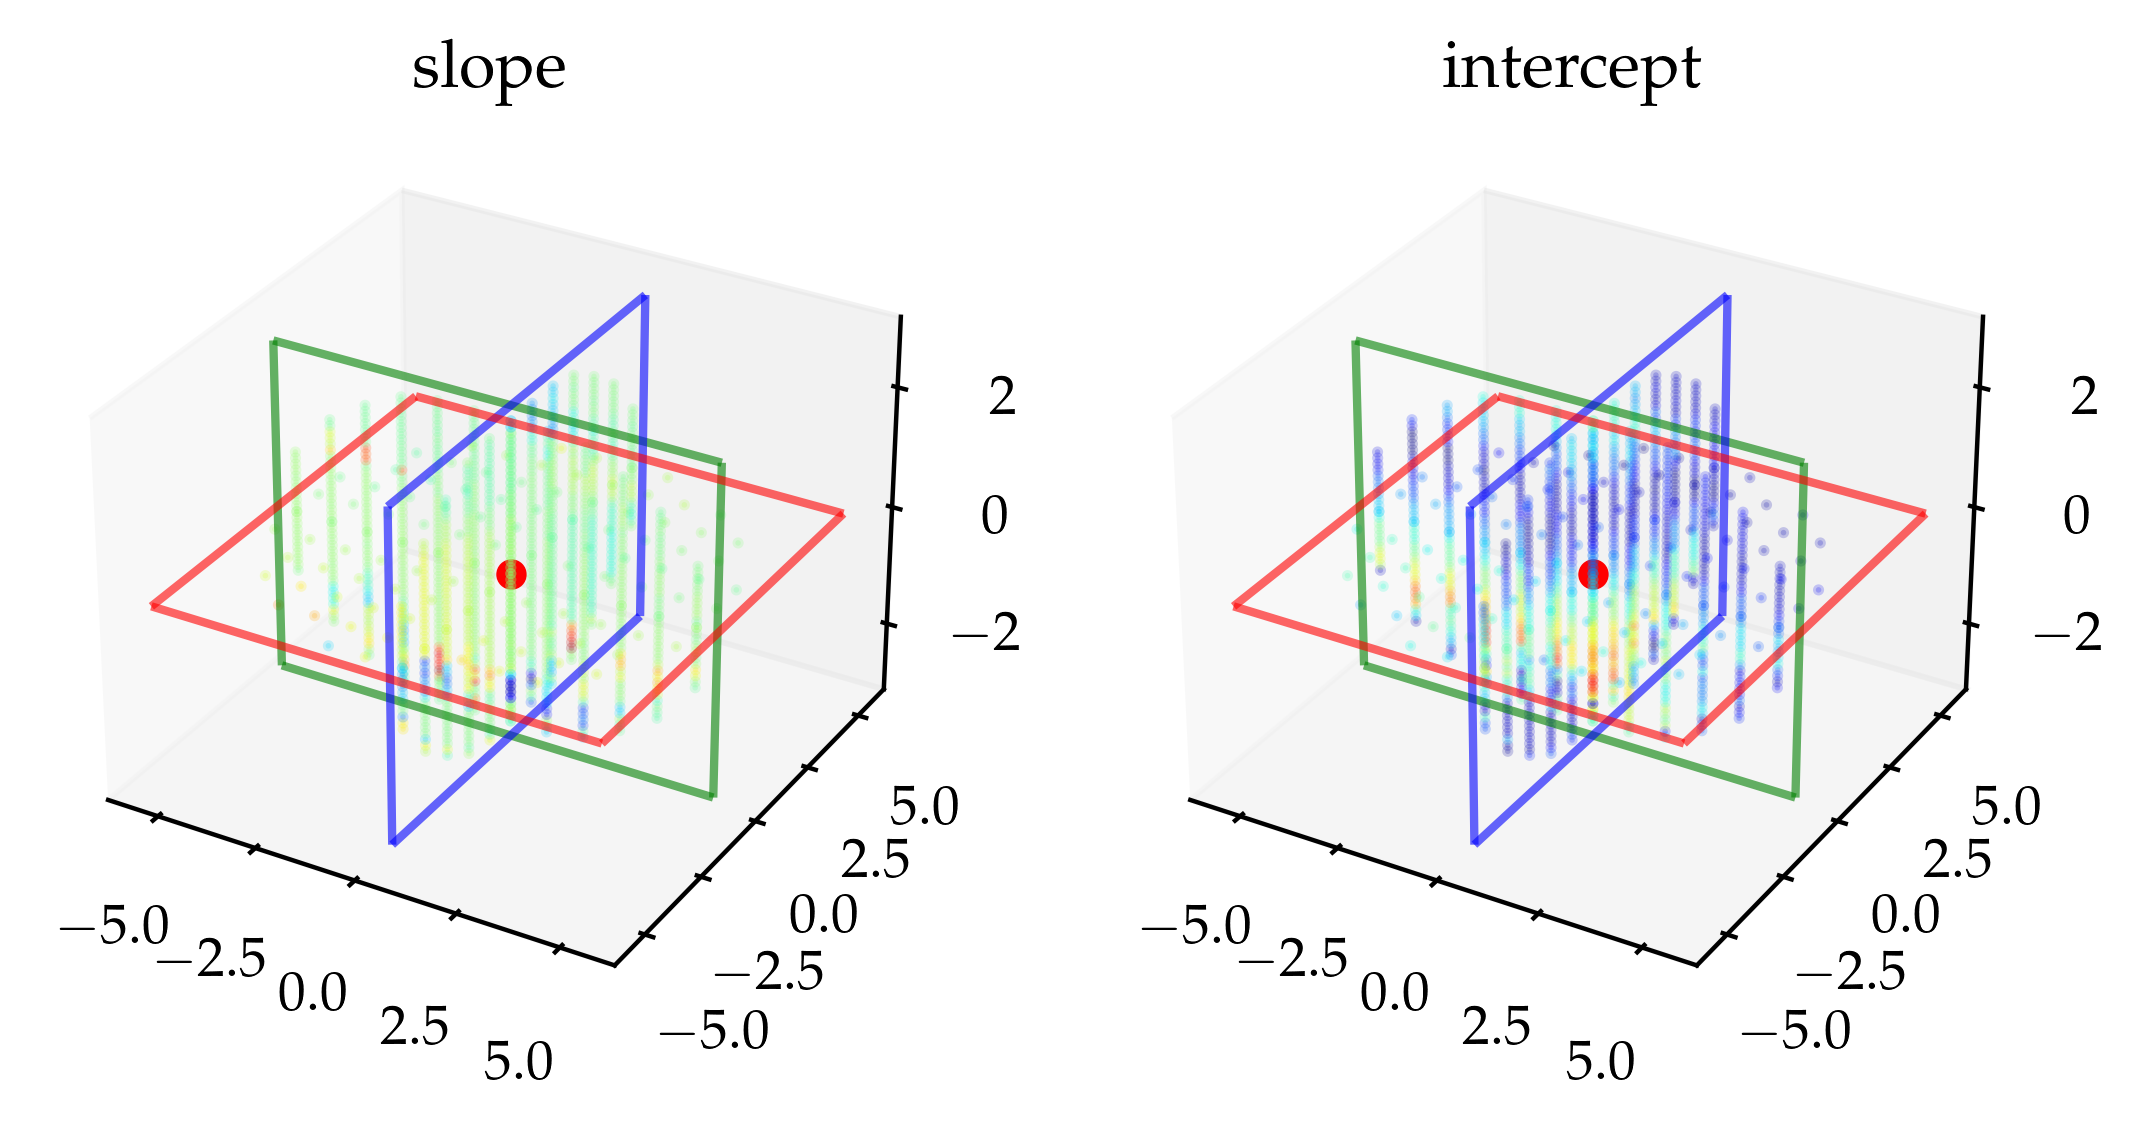

In [213]:
fig = plt.figure()
_alpha = 0.2

for i in range(num_channels):
    ax = fig.add_subplot(1,num_channels, i+1,projection='3d')

    data_col = data_labels[i]
    # ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2[data_col], cmap='jet', alpha=0.2,s=1)
    # ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat[data_col], cmap='jet', alpha=0.005)#,s=9)
    # ax.scatter(zmps[i]['Rx'], zmps[i]['Ry'], np.ones(zmps[i]['Ry'].shape) * mp.loc[i]['Z'], c=zmps[i][data_col], cmap='jet', alpha=_alpha,s=1)
    # ax.scatter(np.ones(Rxmps[i]['Ry'].shape)* mp.loc[i]['Rx'], Rxmps[i]['Ry'], Rxmps[i]['Z'], c=Rxmps[i][data_col], cmap='jet', alpha=_alpha,s=1)
    # ax.scatter(Rymps[i]['Rx'], np.ones(Rymps[i]['Ry'].shape)* mp.loc[i]['Ry'], Rymps[i]['Z'], c=Rymps[i][data_col], cmap='jet', alpha=_alpha,s=1)
    # ax.scatter(mp.loc[i]['Rx'], mp.loc[i]['Ry'], mp.loc[i]['Z'], color='r')

    ax.scatter(zmps[i]['Rx'], zmps[i]['Ry'], np.ones(zmps[i]['Ry'].shape) * mp['Z'],
        c=zmps[i][data_col], cmap='jet', alpha=_alpha,s=1,norm=offsets[i])
    ax.scatter(np.ones(Rxmps[i]['Ry'].shape)* mp['Rx'], Rxmps[i]['Ry'], Rxmps[i]['Z'],
        c=Rxmps[i][data_col], cmap='jet', alpha=_alpha,s=1,norm=offsets[i])
    ax.scatter(Rymps[i]['Rx'], np.ones(Rymps[i]['Ry'].shape)* mp['Ry'], Rymps[i]['Z'],
        c=Rymps[i][data_col], cmap='jet', alpha=_alpha,s=1,norm=offsets[i])
    ax.scatter(mp['Rx'], mp['Ry'], mp['Z'], color='r')

    ax.set_title(f"{data_col}")
    # tax.scatter3D(zmps[i]['Rx'], zmps[i]['Ry'], zmps[i][data_col],c=zmps[i][data_col], cmap='jet',s=4)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    ax.grid(False)
    # ax.xaxis.pane.set_visible(False)
    # ax.yaxis.pane.set_visible(False)
    # ax.zaxis.pane.set_visible(False)

    alpha = 0.6
    # Slice through the Rx-Ry plane with maximum Z
    X,Y = np.meshgrid(xlim,ylim)
    Z = np.ones(X.shape)*mp['Z']
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='r', alpha=alpha)
    # Slice through the Rx-Z plane with maximum Ry
    X,Z = np.meshgrid(xlim,zlim)
    Y = np.ones(X.shape)*mp['Ry']
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='g', alpha=alpha)
    # Slice through the Rx-Ry plane with maximum Z
    Z,Y = np.meshgrid(zlim,ylim)
    X = np.ones(X.shape)*mp['Rx']
    ax.plot_wireframe(X=X, Y=Y, Z=Z, color='b', alpha=alpha)

if save_figs:
    plt.savefig(f"figures\\Scan_{file_no}\\data_slice2.jpg")

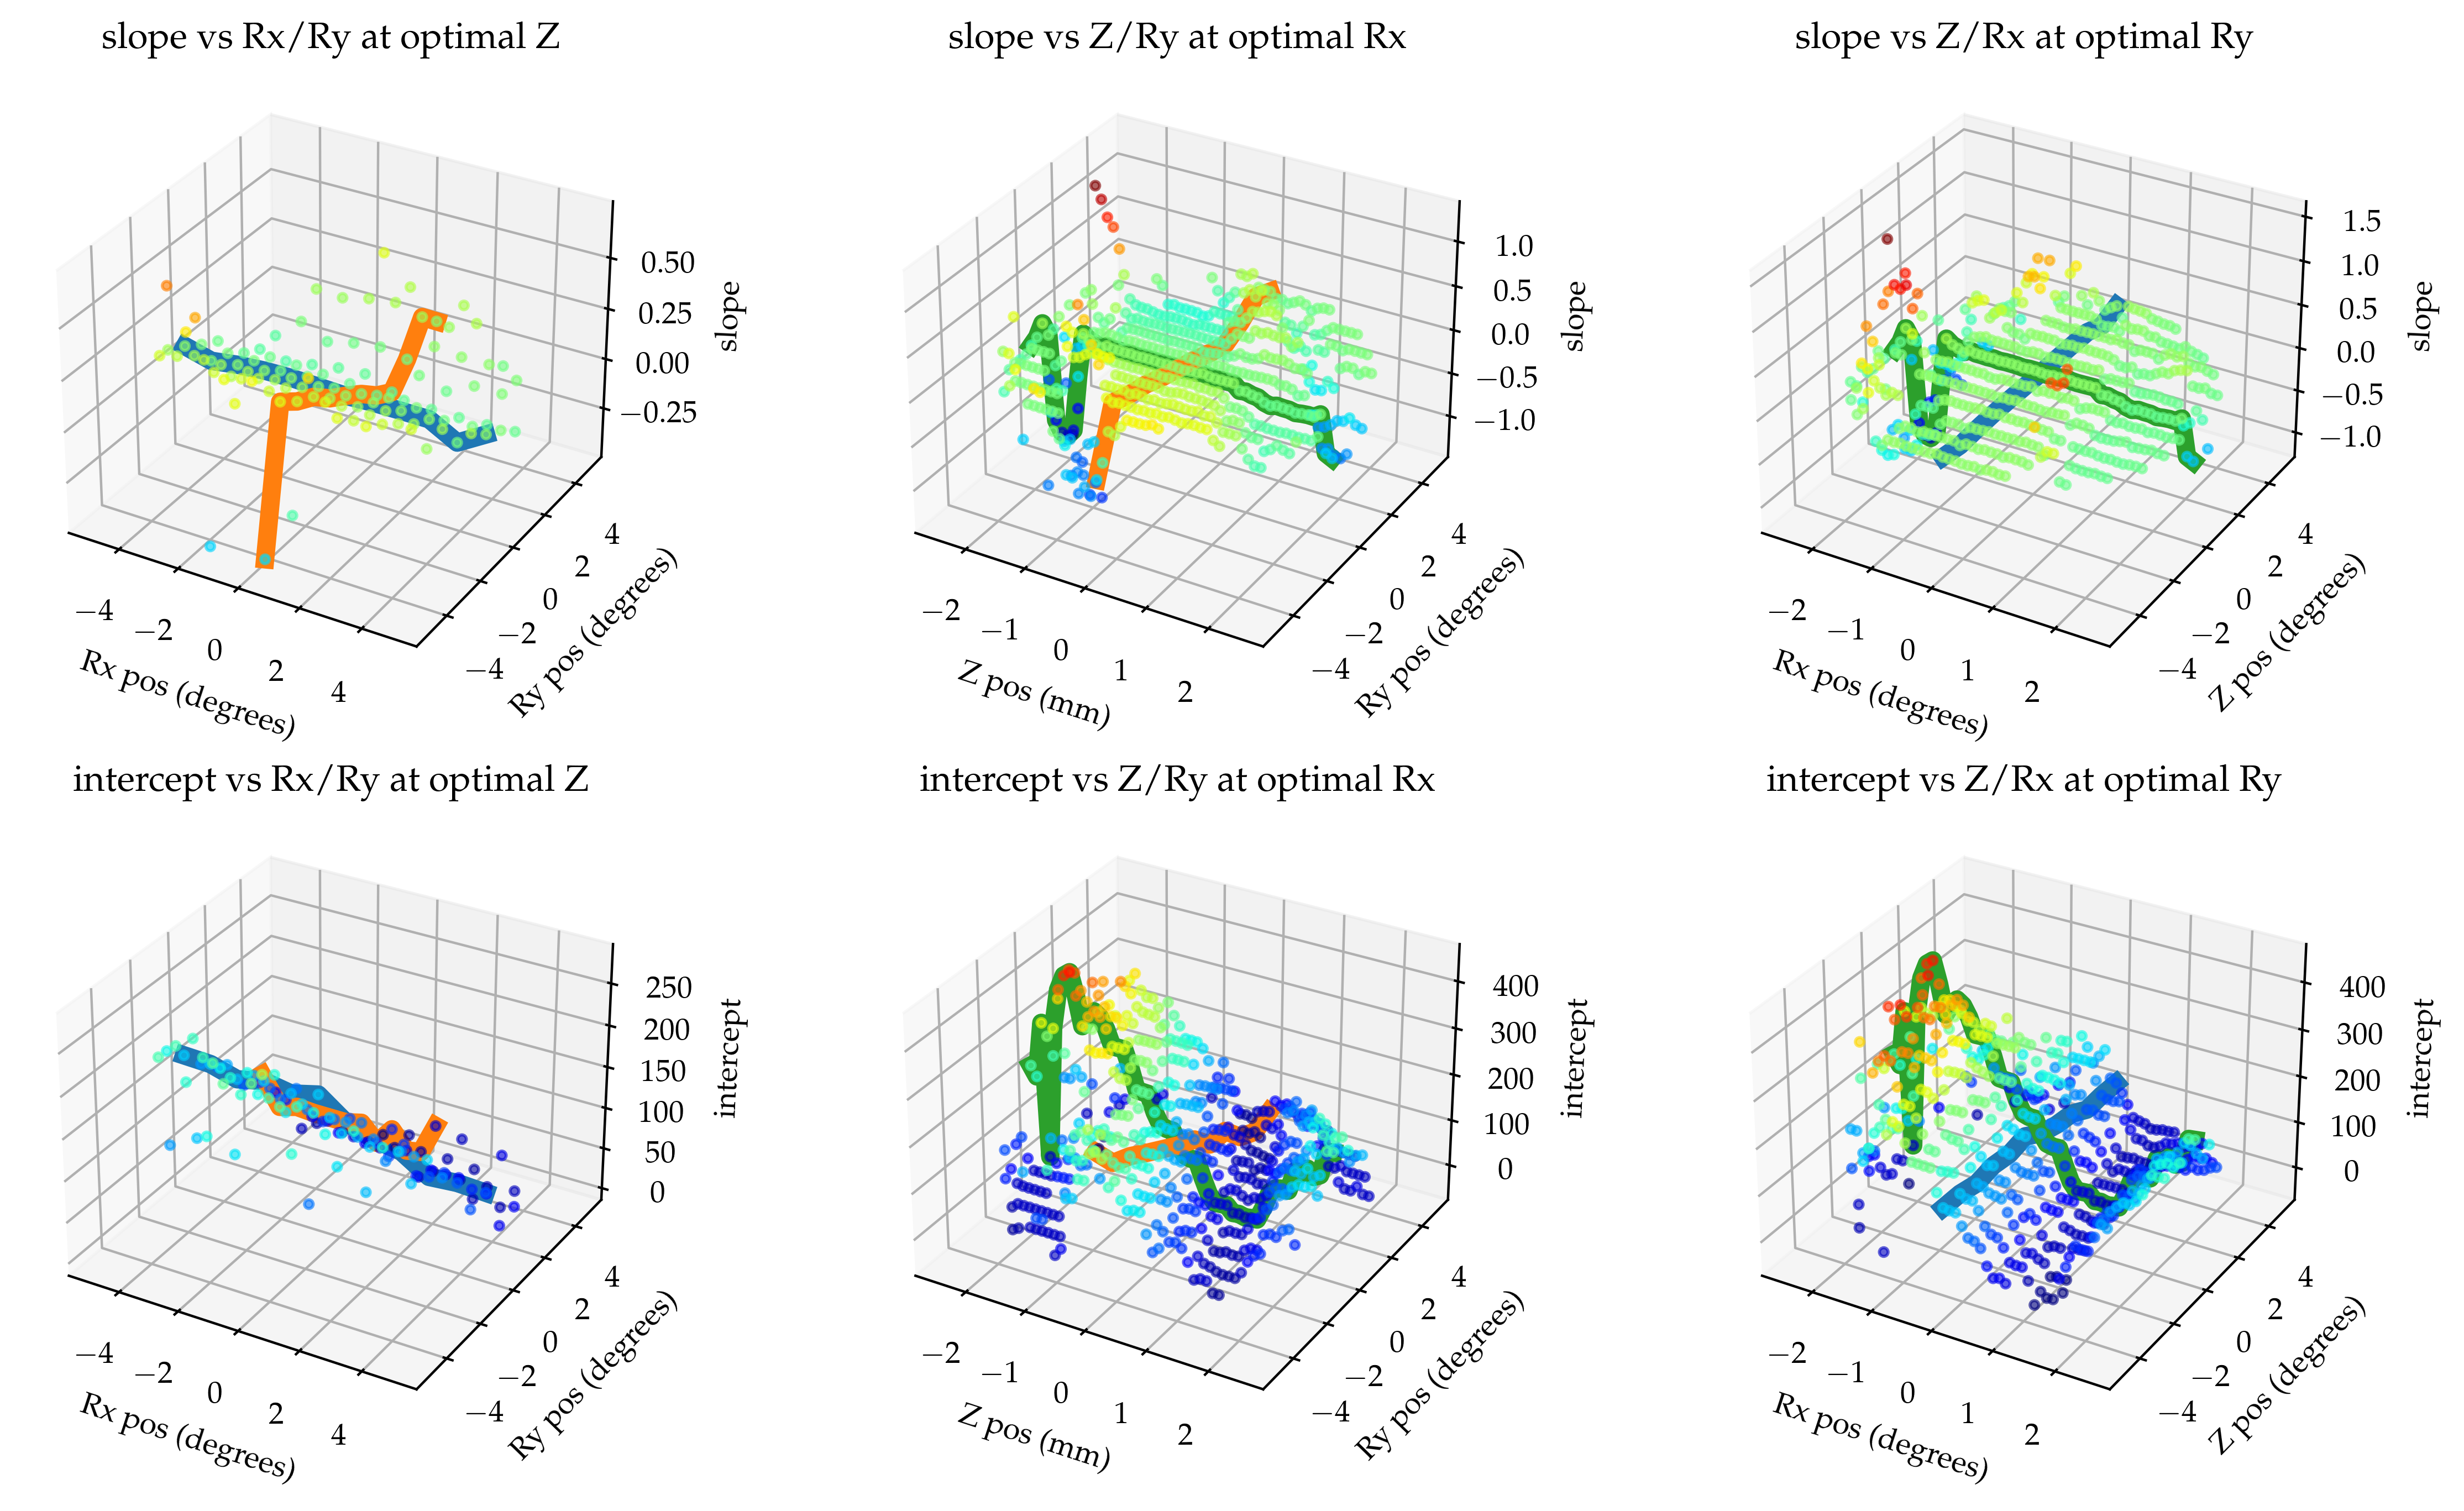

In [223]:
fig2 = plt.figure(figsize=(14,4*num_channels))
# fig2 = plt.figure()

s,alpha,lw = 8,0.6,6

# tax = plt.figure()
# tax = plt.axes(projection="3d")
for i in range(num_channels):
    data_col = data_labels[i]
    tax = fig2.add_subplot(num_channels,3,1+(3*i), projection='3d')
    # tax = plt.axes(projection='3d')
    tax.scatter3D(zmps[i]['Rx'], zmps[i]['Ry'], zmps[i][data_col],c=zmps[i][data_col],
        cmap='jet',s=s, alpha=alpha,norm=offsets[i])
    tax.plot3D(Rx_isolated_mps[i]['Rx'], Rx_isolated_mps[i]['Ry'], Rx_isolated_mps[i][data_col], c='C0', linewidth=lw)
    tax.plot3D(Ry_isolated_mps[i]['Rx'], Ry_isolated_mps[i]['Ry'], Ry_isolated_mps[i][data_col], c='C1', linewidth=lw)
    tax.set_title(f"{data_col} vs Rx/Ry at optimal Z")
    tax.set_xlabel("Rx pos (degrees)")
    tax.set_ylabel("Ry pos (degrees)")
    tax.set_zlabel(f"{data_col}")

    # tax.grid(False)
    # ax.xaxis.pane.set_visible(False)
    # ax.yaxis.pane.set_visible(False)
    # ax.zaxis.pane.set_visible(False)

    tax = fig2.add_subplot(num_channels,3,2+(3*i), projection='3d')
    tax.scatter(Rxmps[i]['Z'], Rxmps[i]['Ry'], Rxmps[i][data_col],c=Rxmps[i][data_col],
        cmap='jet',s=s, alpha=alpha,norm=offsets[i])
    tax.plot3D(z_isolated_mps[i]['Z'], z_isolated_mps[i]['Ry'], z_isolated_mps[i][data_col],c='C2', linewidth=lw)
    tax.plot3D(Ry_isolated_mps[i]['Z'], Ry_isolated_mps[i]['Ry'], Ry_isolated_mps[i][data_col],c='C1', linewidth=lw)
    tax.set_title(f"{data_col} vs Z/Ry at optimal Rx")
    tax.set_xlabel("Z pos (mm)")
    tax.set_ylabel("Ry pos (degrees)")
    tax.set_zlabel(f"{data_col}")

    tax = fig2.add_subplot(num_channels,3,3+(3*i), projection='3d')
    # tax.plot_trisurf(Rymps[:,0], Rymps[:,1], Rymps[:,3], cmap='jet')
    tax.scatter(Rymps[i]['Z'], Rymps[i]['Rx'], Rymps[i][data_col],c=Rymps[i][data_col],
        cmap='jet',s=s, alpha=alpha,norm=offsets[i])
    tax.plot(Rx_isolated_mps[i]['Z'], Rx_isolated_mps[i]['Rx'], Rx_isolated_mps[i][data_col],c='C0', linewidth=lw)
    tax.plot(z_isolated_mps[i]['Z'], z_isolated_mps[i]['Rx'], z_isolated_mps[i][data_col],c='C2', linewidth=lw)
    tax.set_title(f"{data_col} vs Z/Rx at optimal Ry")
    tax.set_ylabel("Z pos (degrees)")
    tax.set_xlabel("Rx pos (degrees)")
    tax.set_zlabel(f"{data_col}")

if save_figs:
    plt.savefig(f"figures\\Scan_{file_no}\\Isolated_axes_w_trace.jpg")
plt.show()

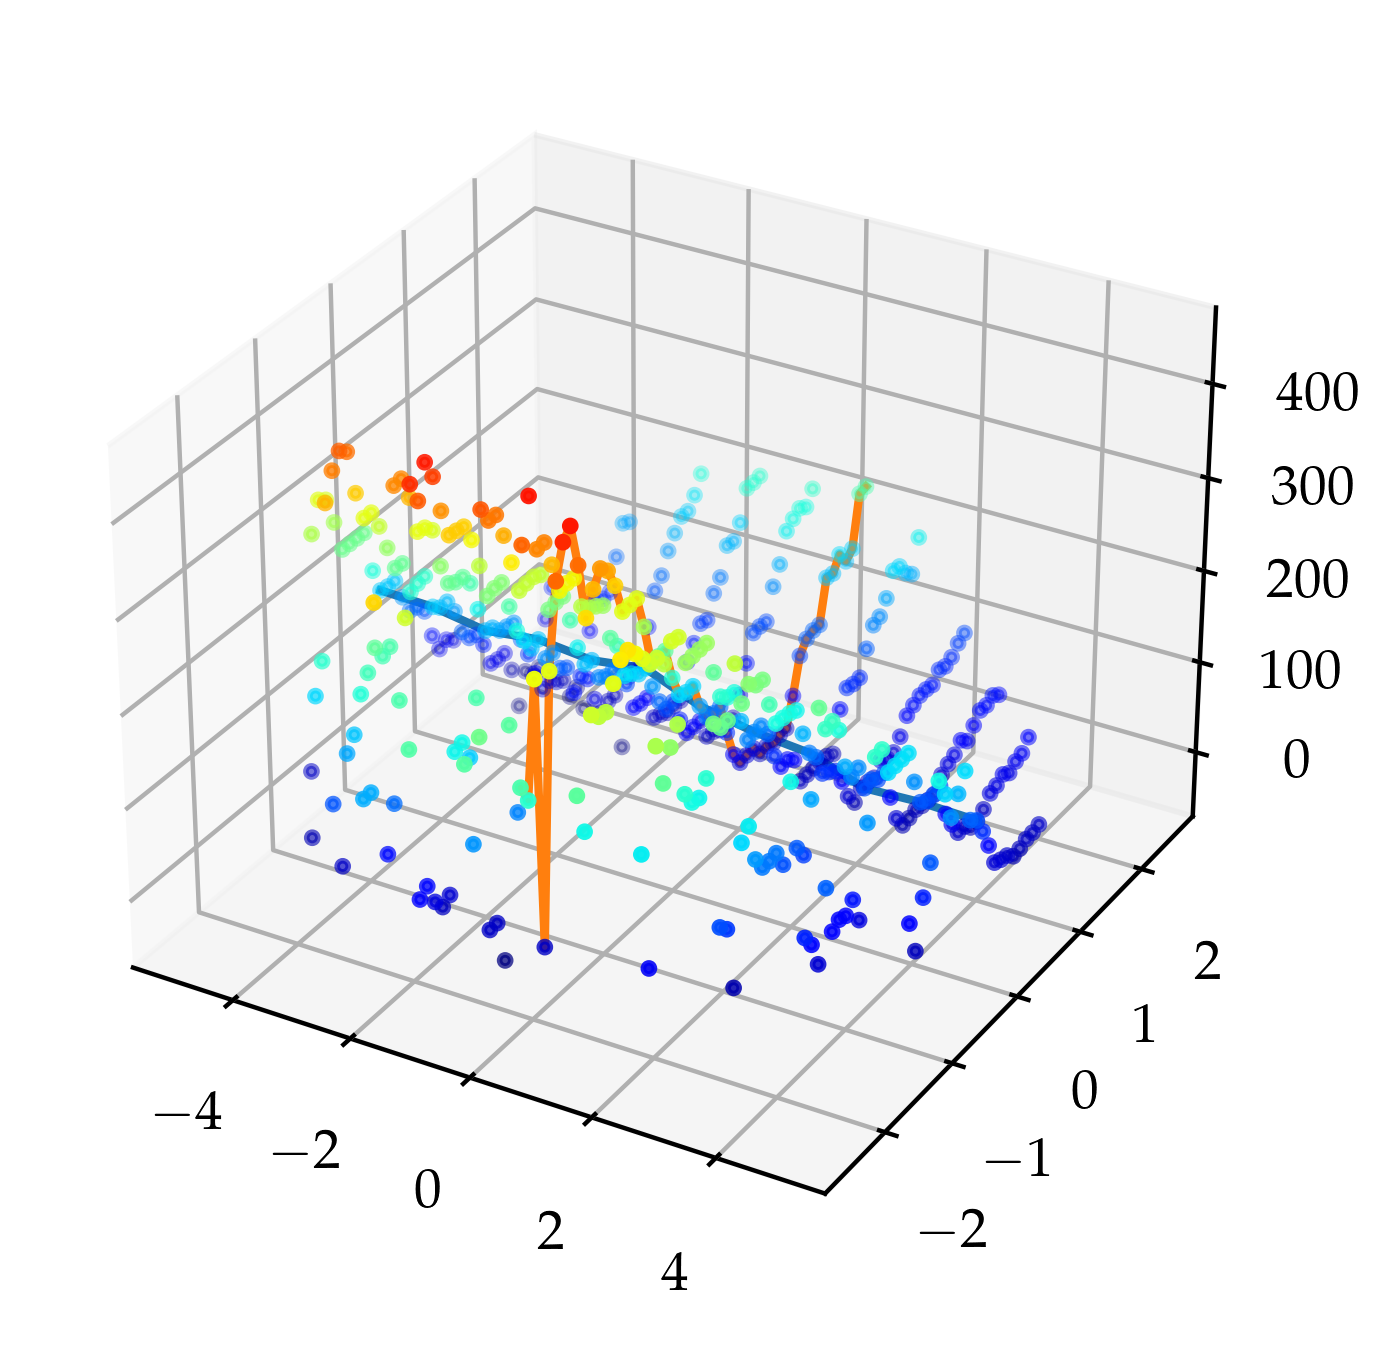

In [215]:
fig2 = plt.figure(figsize=(4,4), constrained_layout=False)
tax = fig2.add_subplot(projection='3d')
data_col = data_labels[1]

# tax.scatter3D(zmps[i]['Rx'], zmps[i]['Ry'], zmps[i][data_col],c=zmps[i][data_col], cmap='jet',s=4)
# tax.plot3D(Rx_isolated_mps[i]['Rx'], Rx_isolated_mps[i]['Ry'], Rx_isolated_mps[i][data_col],c='C0')
# tax.plot3D(Ry_isolated_mps[i]['Rx'], Ry_isolated_mps[i]['Ry'], Ry_isolated_mps[i][data_col],c='C1')
# tax.set_title("magnitude vs Rx/Ry at optimal Z")
# tax.set_xlabel("Rx pos (degrees)")
# tax.set_ylabel("Ry pos (degrees)")
# tax.set_zlabel("Signal magnitude (mV)")

# tax.scatter3D(Rxmps[i]['Z'], Rxmps[i]['Ry'], Rxmps[i][data_col],c=Rxmps[i][data_col], cmap='jet',s=4)
# tax.plot3D(z_isolated_mps[i]['Z'], z_isolated_mps[i]['Ry'], z_isolated_mps[i][data_col],c='C0')
# tax.plot3D(Ry_isolated_mps[i]['Z'], Ry_isolated_mps[i]['Ry'], Ry_isolated_mps[i][data_col],c='C1')

tax.scatter(Rymps[i]['Rx'], Rymps[i]['Z'], Rymps[i][data_col],c=Rymps[i][data_col], cmap='jet',s=4,norm=offsets[i])
tax.plot(Rx_isolated_mps[i]['Rx'], Rx_isolated_mps[i]['Z'], Rx_isolated_mps[i][data_col],c='C0')
tax.plot(z_isolated_mps[i]['Rx'], z_isolated_mps[i]['Z'], z_isolated_mps[i][data_col],c='C1')

if save_figs:
    plt.savefig(f"figures\\Scan_{file_no}\\Isolated_axes_1.jpg")

In [216]:
def normalize(X):
    min = X.min()
    max = X.max()

    return (X-min) / (max - min)

Rxmps[i]

Z        Rx   Ry    slope  intercept
37   -1.0  0.454545 -5.0  0.40769   97.89124
38   -0.9  0.454545 -5.0  0.38704   98.99632
39   -0.8  0.454545 -5.0 -0.62662  207.59011
40   -0.7  0.454545 -5.0 -0.00094   30.26398
41   -0.6  0.454545 -5.0 -0.06374   48.07665
...   ...       ...  ...      ...        ...
4025  0.6  0.454545  5.0 -0.01808   48.45842
4026  0.7  0.454545  5.0 -0.07064   59.63030
4027  0.8  0.454545  5.0 -0.02249   36.28466
4028  0.9  0.454545  5.0 -0.00067   30.18229
4029  1.0  0.454545  5.0 -0.00010   30.02729

[500 rows x 5 columns]

Guess: [32, 153.6, 0, 128]
Fin: [3.8551, 44.4462, 70.2931, 51.5832]
R2: 0.20380813742936832
R2: -1.5074962726794032


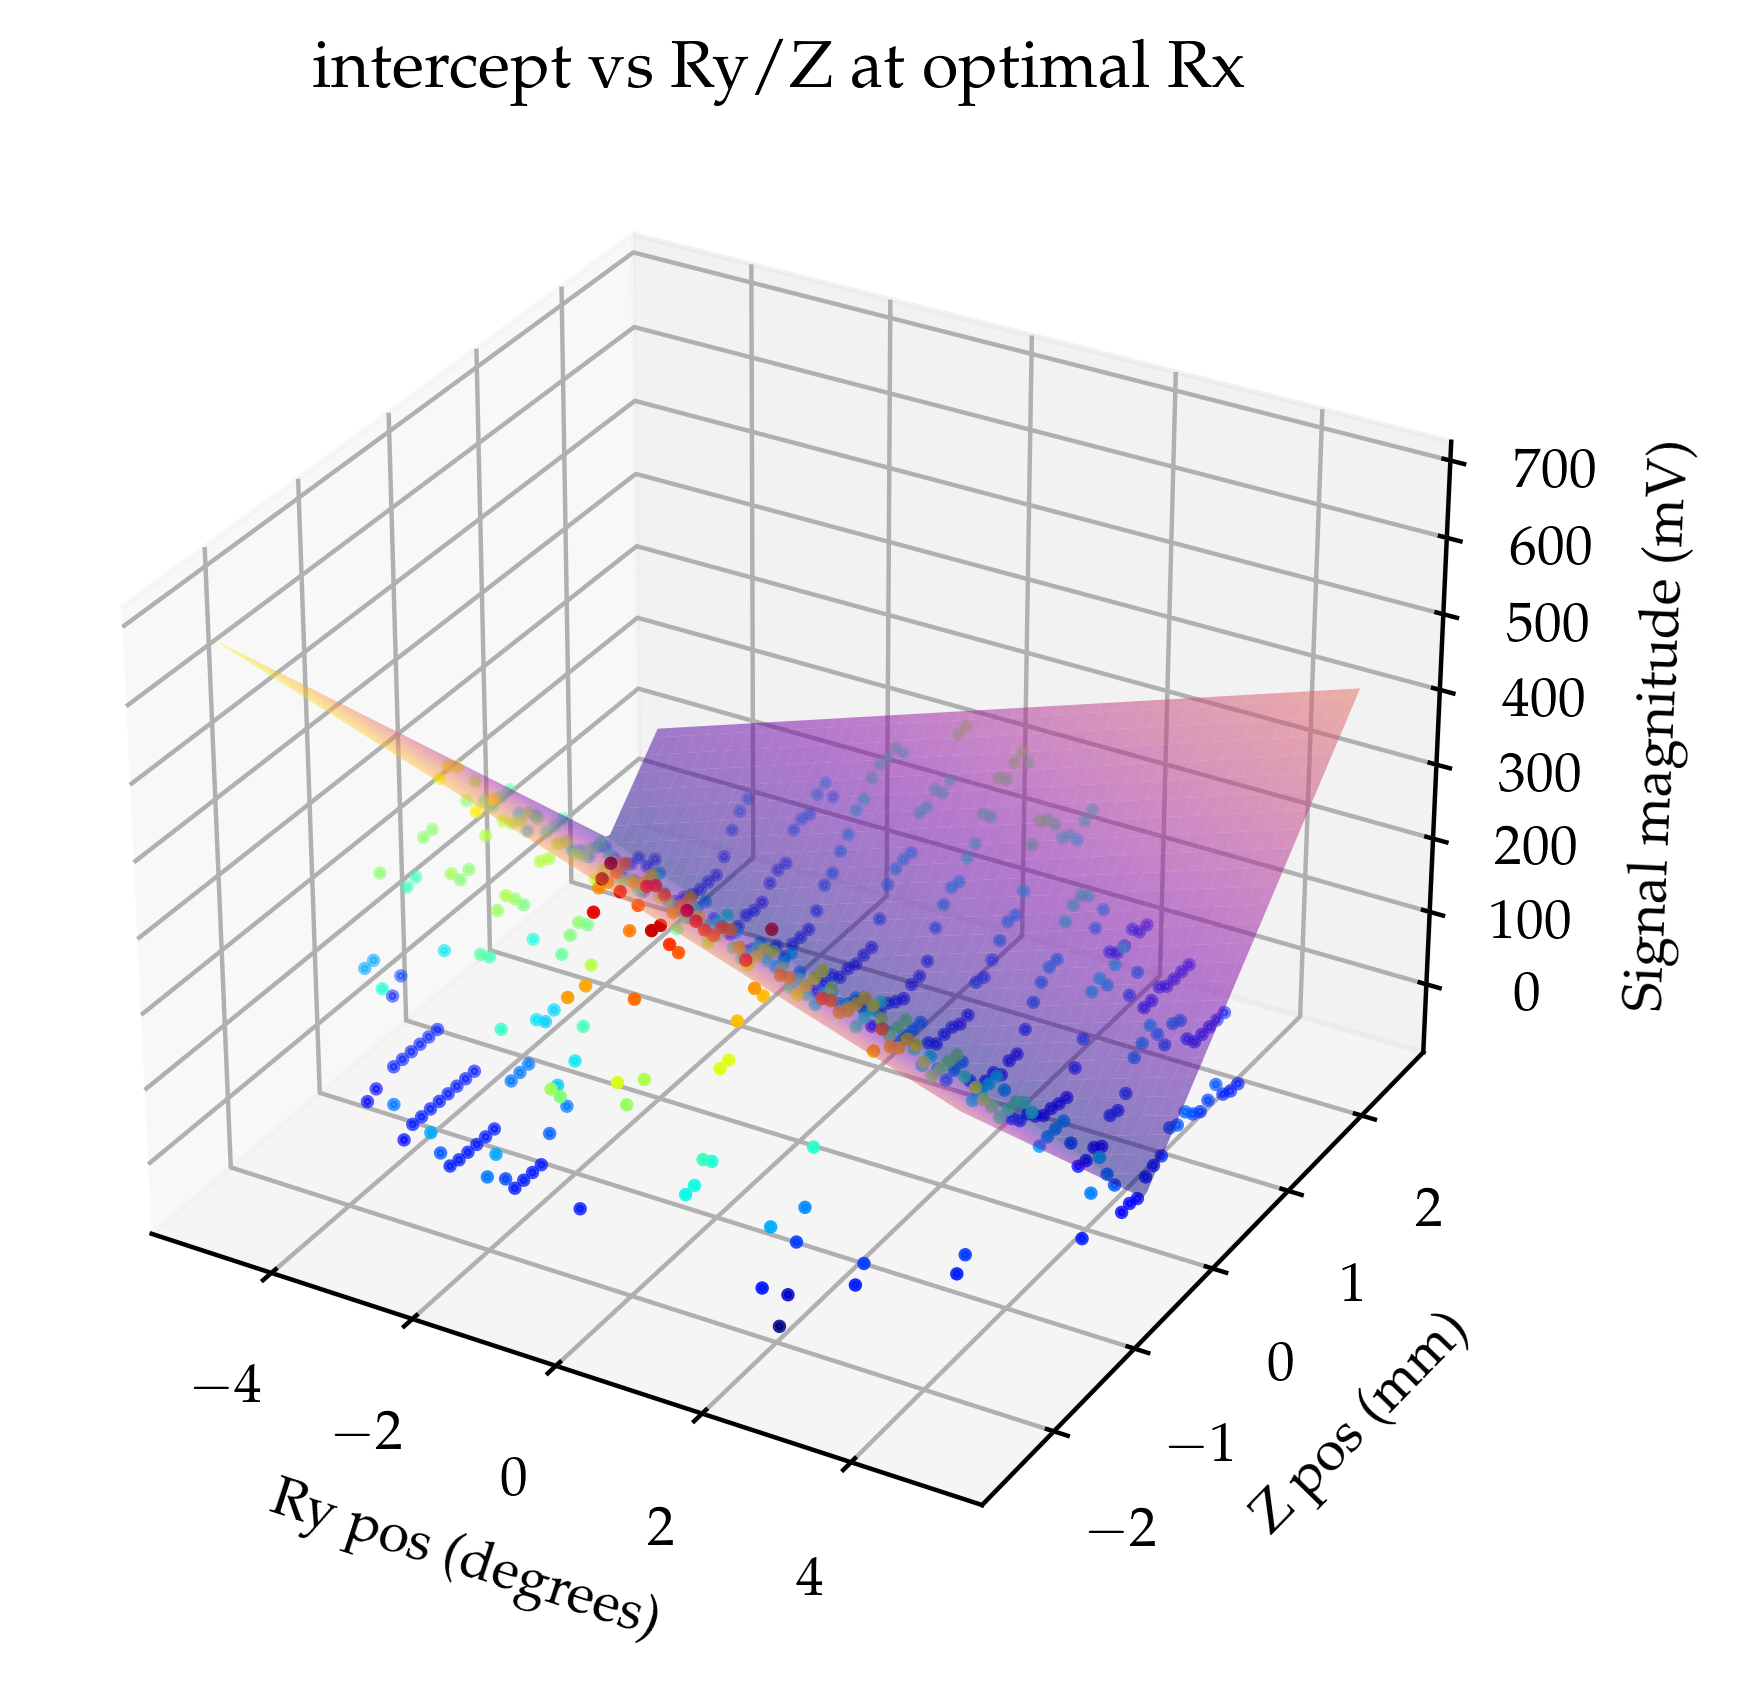

In [217]:
# (X,Y,Z,title,xlable,ylable,guess) = (zmps[i]['Rx'],zmps[i]['Ry'],zmps[i][data_col],"magnitude vs Ry/Rx at optimal Z","Rx pos (degrees)","Ry pos (degrees)",[600,60,mp['Rx'],mp['Ry'],med])
# (X,Y,Z,title,xlable,ylable,guess) = (Rxmps[i]['Ry'],Rxmps[i]['Z'],Rxmps[i][data_col],"magnitude vs Ry/Z at optimal Rx","Ry pos (degrees)","Z pos (mm)",[800,0.1,1,mp['Ry'],mp['Z'],med[i]])
# (X,Y,Z,title,xlable,ylable,guess) = (Rymps[i]['Ry'],Rymps[i]['Z'],Rymps[i][data_col],"magnitude vs Rx/Z at optimal Ry","Z pos (mm)","Rx pos (degrees)",[1,1,1,1,mp['Z'],mp['Ry'],med])

a = 32

(X,Y,Z,title,xlable,ylable,guess) = (Rxmps[i]['Ry'],
                                    Rxmps[i]['Z'],
                                    Rxmps[i][data_col],
                                    f"{data_col} vs Ry/Z at optimal Rx","Ry pos (degrees)",
                                    "Z pos (mm)",
                                    [a,a*4.8,0,4*a])

# (X,Y,Z) = (normalize(X),normalize(Y),normalize(Z))

test_func = abs_plane

popt, pcov = curve_fit(test_func, [X, Y], Z,p0=guess,maxfev=5000)
# popt, pcov = curve_fit(double_ang,[X,Y],Z)
# print(popt)
print(f"Guess: {guess}")
# popt, pcov = curve_fit(double_ang,[X,Y],Z,p0=guess)
print(f"Fin: {[round(i,4) for i in popt]}")
print(f"R2: {r_squared(test_func, popt, [X, Y], Z)}")
print(f"R2: {r_squared(test_func, guess, [X, Y], Z)}")


# create surface function model
# setup data points for calculating surface model
model_y_data = np.linspace(min(Y), max(Y), 100)
model_x_data = np.linspace(min(X), max(X), 100)
# create coordinate arrays for vectorized evaluations
Xs, Ys = np.meshgrid(model_x_data, model_y_data)
# calculate Z coordinate array
# Zs = test_func(np.array([Xs, Ys]), *popt)
Zs = test_func(np.array([Xs,Ys]), *guess)


fig3 = plt.figure()

tax = plt.axes(projection="3d")
# tax = fig3.add_subplot(1,2,1, projection='3d')

tax.scatter3D(X,Y,Z,cmap='jet',c=Z,s=2)
tax.set_title(title)
tax.set_xlabel(xlable)
tax.set_ylabel(ylable)
tax.set_zlabel("Signal magnitude (mV)")
# tax.axis("off")
tax.plot_surface(Xs,Ys,Zs, cmap='plasma',alpha=0.5)
# tax.view_init(0,0)

# tax2 = fig3.add_subplot(1,2,2, projection='3d')

# tax2.scatter3D(X,Y,Z,cmap='jet',c=Z,s=2)
# # tax2.set_title(title)
# # tax.set_xlabel(xlable)
# # tax.set_ylabel(ylable)
# # tax.set_zlabel("Signal magnitude (mV)")
# tax2.axis("off")
# tax2.plot_surface(Xs,Ys,Zs, cmap='plasma',alpha=0.5)
# # tax2.view_init(0,90)


if save_figs:
    tax.get_figure().savefig(f"figures\\Scan_{file_no}\\Fullscan_2d_fit.jpg")

In [218]:
med

[0.00014, 111.82207]

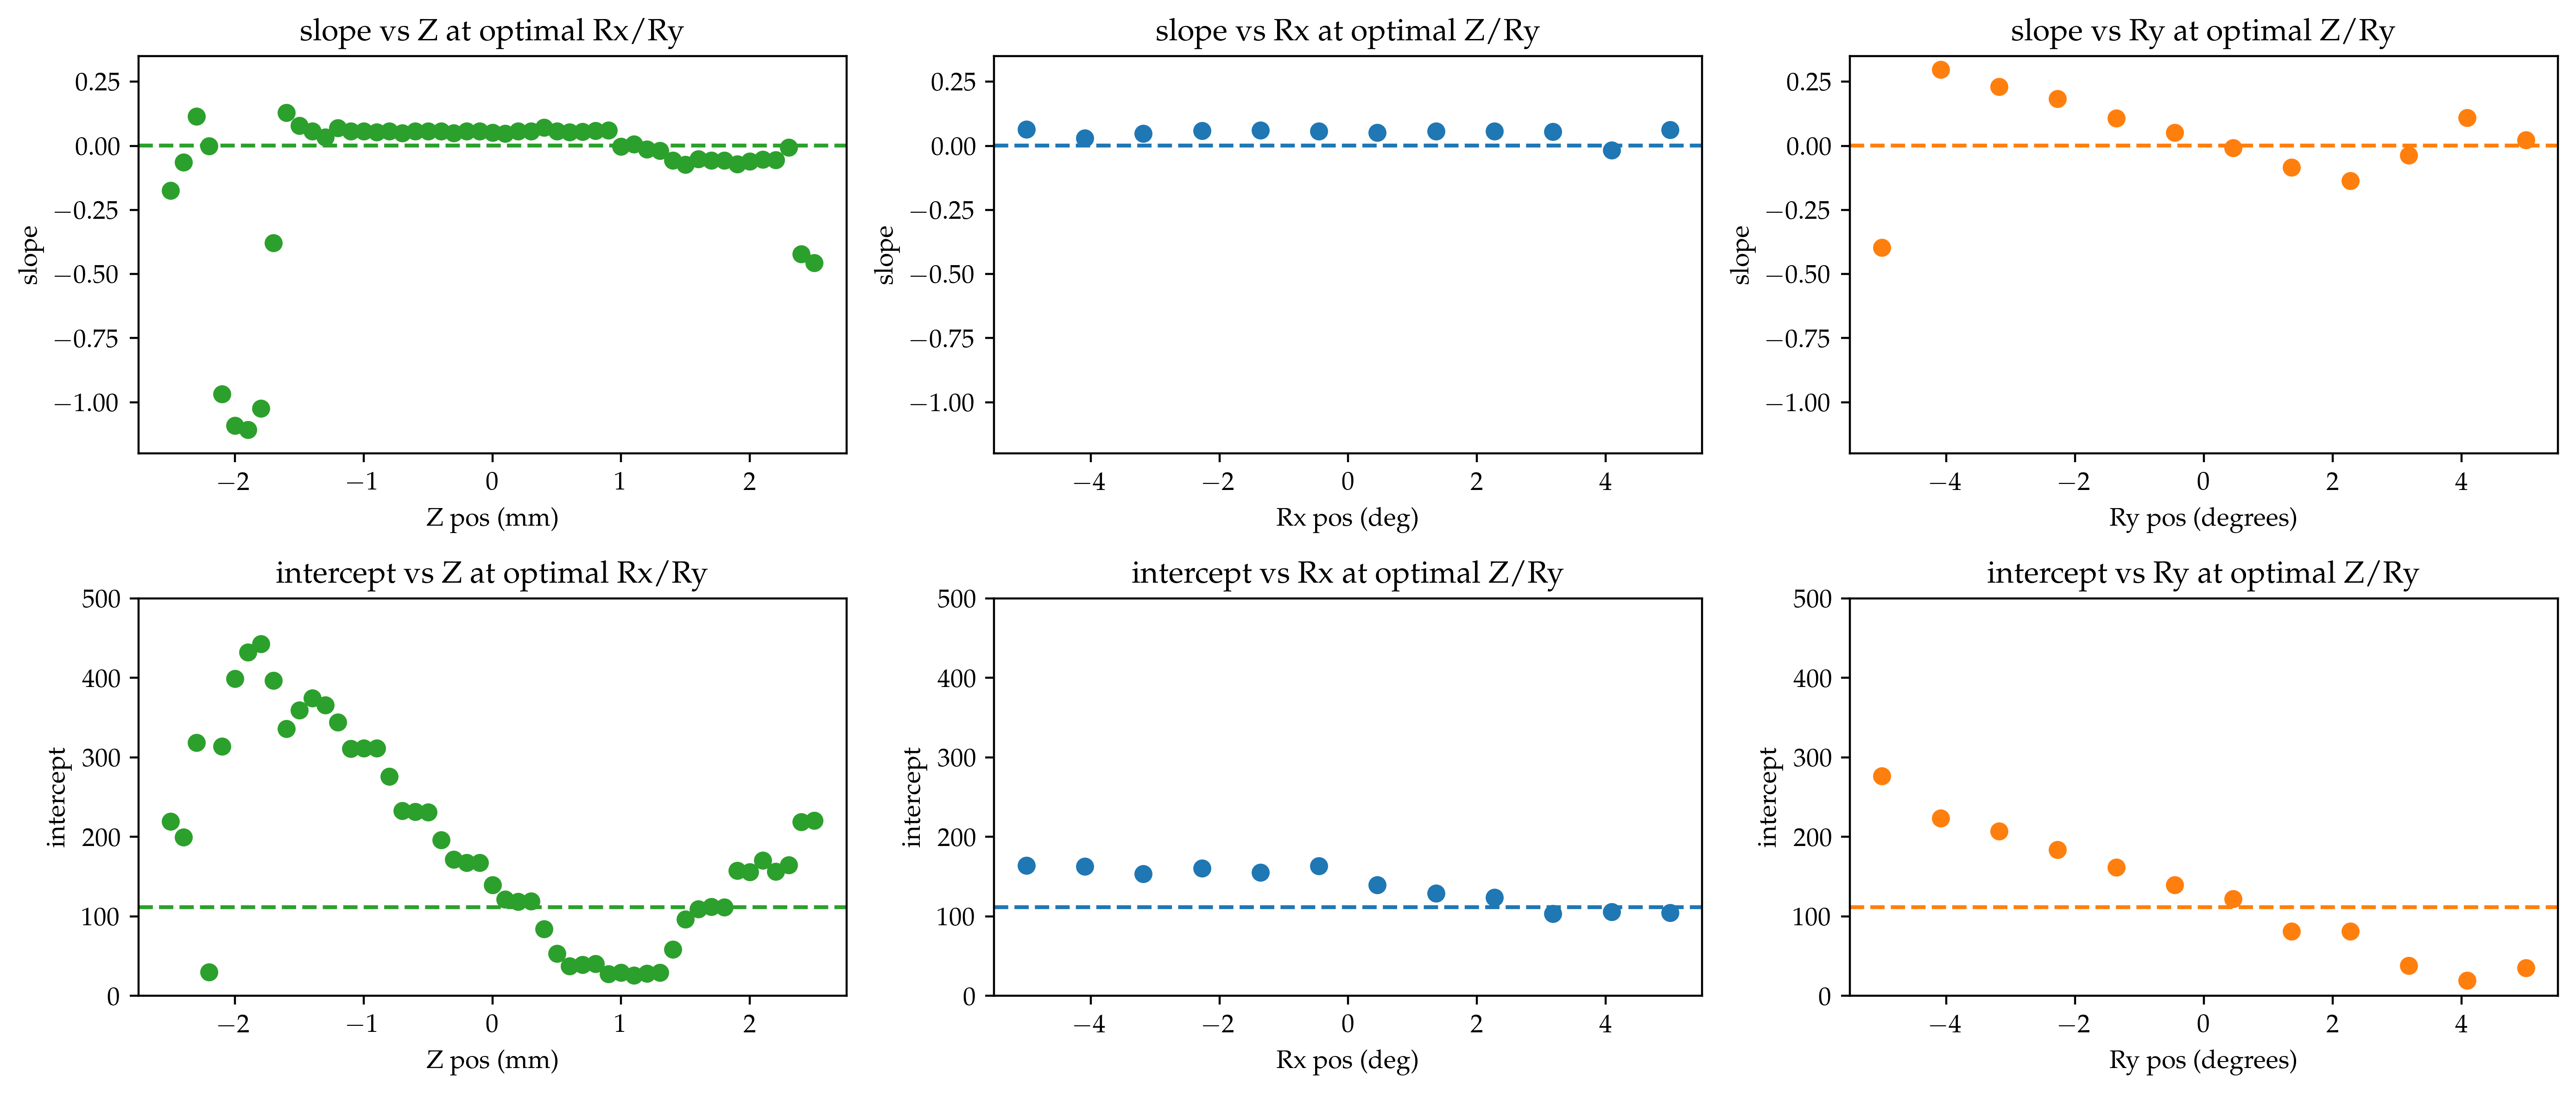

In [227]:
fig3 = plt.figure(figsize=(14,3*num_channels))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.8, 
#                     hspace=0.4)

lims = [(-1.2,0.35), (0,500)]

for i in range(num_channels):
    data_col = data_labels[i]
    tax = fig3.add_subplot(num_channels,3,1+(3*i))
    tax.scatter(z_isolated_mps[i]['Z'],z_isolated_mps[i][data_col], c='C2')
    tax.axhline(med[i], c='C2',ls='--')
    # tax.axhline(np.median(dat[data_col]), c='r',ls='--')
    tax.set_title(f"{data_col} vs Z at optimal Rx/Ry")
    tax.set_xlabel("Z pos (mm)")
    tax.set_ylabel(data_col)
    tax.set_ylim(lims[i])

    tax = fig3.add_subplot(num_channels,3,2+(3*i))
    tax.scatter(Rx_isolated_mps[i]['Rx'],Rx_isolated_mps[i][data_col], c='C0')
    tax.axhline(med[i], c='C0',ls='--')
    tax.set_title(f"{data_col} vs Rx at optimal Z/Ry") 
    tax.set_xlabel("Rx pos (deg)")
    tax.set_ylabel(data_col)
    tax.set_ylim(lims[i])

    tax = fig3.add_subplot(num_channels,3,3+(3*i))
    tax.scatter(Ry_isolated_mps[i]['Ry'],Ry_isolated_mps[i][data_col], c='C1')
    tax.axhline(med[i], c='C1',ls='--')
    tax.set_title(f"{data_col} vs Ry at optimal Z/Ry")
    tax.set_xlabel("Ry pos (degrees)")
    tax.set_ylabel(data_col)
    tax.set_ylim(lims[i])

fig3.tight_layout()

if save_figs:
    plt.savefig(f"figures\\Scan_{file_no}\\Single-axis magnitude plots.jpg")

Simple absolute value function: [151.42149164  -0.55514579   0.98075698]
2nd order polynomial: [  61.40406936 -115.89095673  119.39019058]
None couldn't converge.


c:\Users\ander\OneDrive - UW\Robotics lab material\Robotics Control Code\Ben's Control Code\Debugging Scripts\fit_funcs.py:34: RuntimeWarning: overflow encountered in power
  return (a * (np.e)**(-b * (x-x_offset)**2)) + y_offset


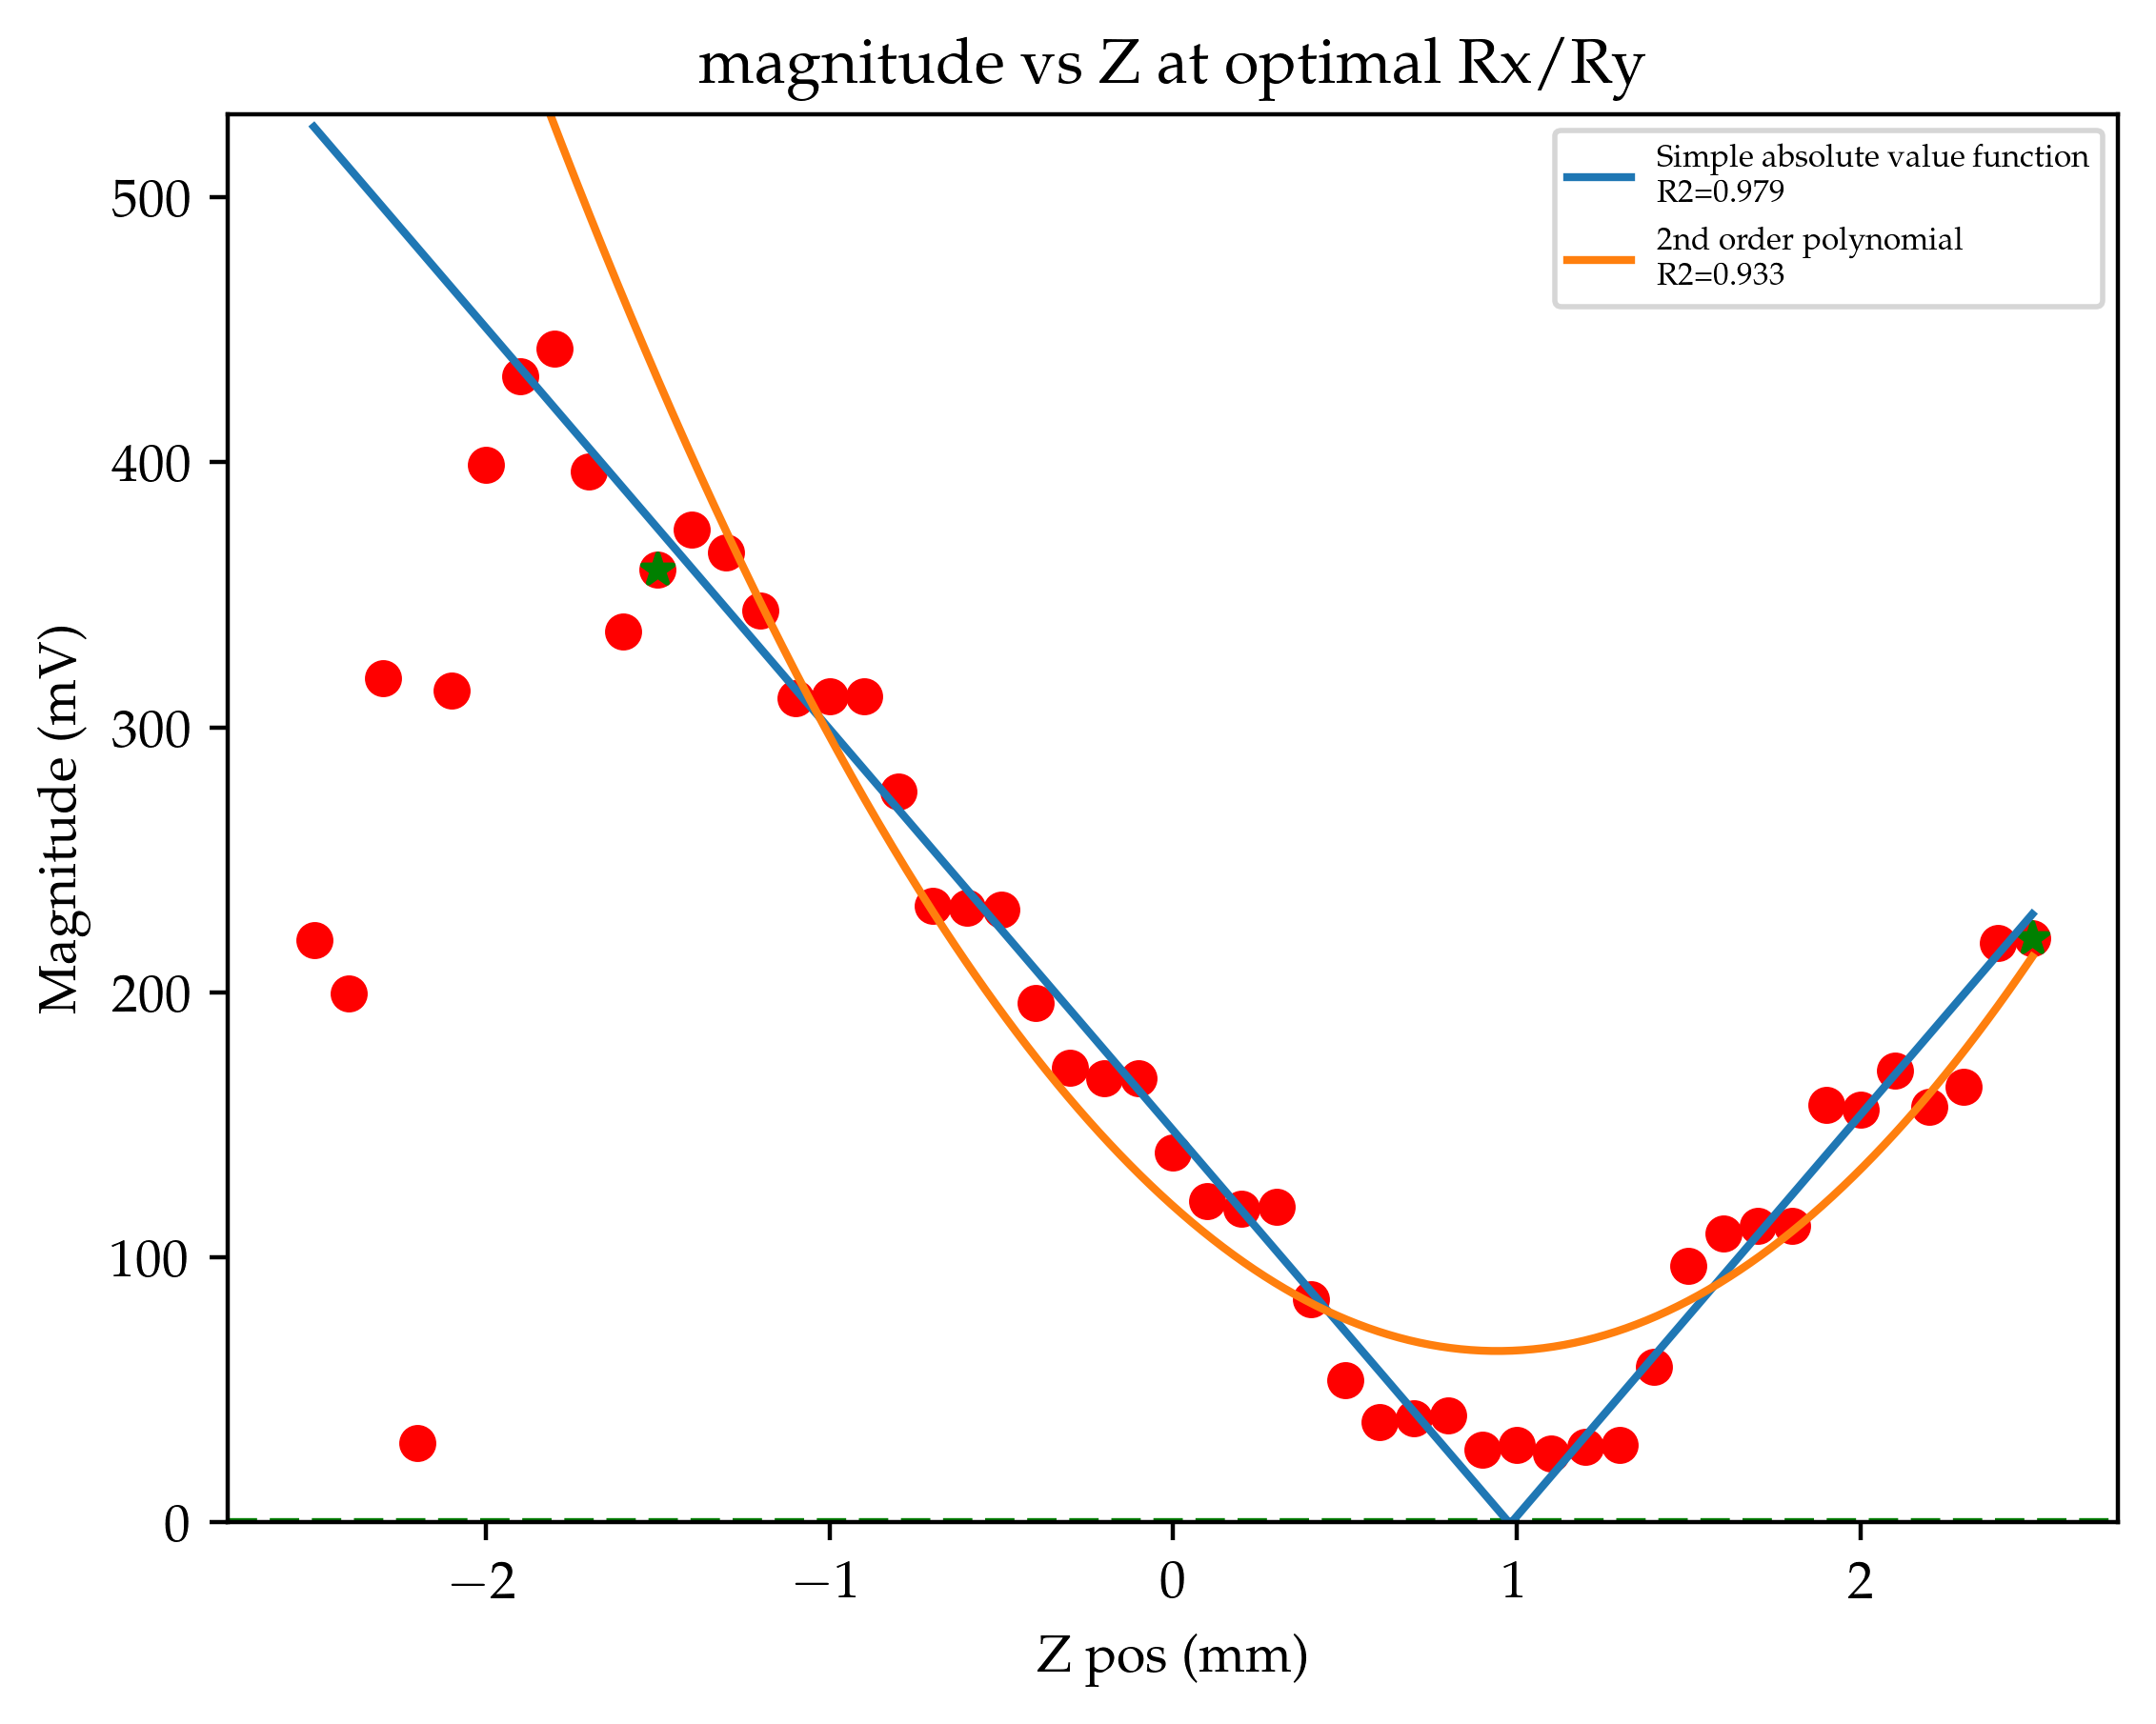

In [220]:
fig4 = plt.axes()
fig4.get_figure()

i = 0

interpolation_windows= { \
    "Z": [10,50], \
    "Rx": [0,11], \
    "Ry": [0,11]}
# interpolation_windows= { \
#     "Z": [8,56], \
#     "Rx": [0,26], \
#     "Ry": [1,26]}
# interpolation_windows= { \
#     "Z": [8,40], \
#     "Rx": [0,26], \
#     "Ry": [1,26]}

t = {'Z': {'data': z_isolated_mps, 'color1': 'r', 'noise': med, 'color2':'g', \
    'header':'magnitude vs Z at optimal Rx/Ry', 'x-axis': "Z pos (mm)"}, \
    'Rx': {'data': Rx_isolated_mps, 'color1': 'g', 'noise': med, 'color2':'b', \
    'header':'magnitude vs Rx at optimal Z/Ry', 'x-axis': "Rx ang (deg)"}, \
    'Ry': {'data': Ry_isolated_mps, 'color1':'b', 'noise': med, 'color2':'r', \
    'header':'magnitude vs Ry at optimal Z/Rx', 'x-axis':"Ry ang (deg)"}}

b = 'Z'
a = interpolation_windows[b]

funcs = [(absolute,[1,1,1]),
        (polynomial_2,[1,1,1]),
        # (rational_2,[1,1,1,1]),
        # (inv_absolute,[1,1,mp[b],med[i]]),
        (gauss,[1,1,mp[b],med[i]])
        ]


fig4.scatter(t[b]['data'][i][b],t[b]['data'][i][data_col], c=t[b]['color1'])
fig4.scatter(t[b]['data'][i][b][a],t[b]['data'][i][data_col][a], c=t[b]['color2'], marker='*')
fig4.axhline(t[b]['noise'][i], c='g',ls='--')

# x = np.linspace(t[b]['data'][b][a[0]],t[b]['data'][b][a[1]],500)
x = np.linspace(min(t[b]['data'][i][b]),max(t[b]['data'][i][b]),500)

x_data = t[b]['data'][i][b][a[0]:a[1]].values
y_data = t[b]['data'][i][data_col][a[0]:a[1]].values

for (fun,guess) in funcs:
    try:
        popt, pcov = curve_fit(fun, x_data, y_data,p0=guess)
        print(f"{fun.__doc__}: {popt}")
        R2 = r_squared(fun, popt, x_data, y_data)
        if R2 > 0:
            fig4.plot(x, fun(x, *popt), label=fun.__doc__ + f"\n R2={R2:0.3f}")
    except RuntimeError as e:
        print(f"{fun.__doc__} couldn't converge.")
    # except ValueError as e:
    #     print("Thing is fucked, here's whats up:")
    #     print(e)
    #     print(f"{x_data},\n{y_data}")

fig4.set_title(t[b]['header'])
fig4.set_xlabel(t[b]['x-axis'])
fig4.set_ylabel("Magnitude (mV)")
fig4.legend(prop={'size':6})
fig4.set_ybound([0, t[b]['data'][i][data_col].max() * 1.2])

In [221]:
# Time to fit,,, all the fucking data

Z=dat["Z"]
Rx=dat["Rx"]
Ry=dat["Ry"]
mag=dat["mag"]

# # Arguments arrangement: double_ang_1, double_ang_2, inv_absolute_1, inv_absolute_2, Rx_offset, Ry_offset, z_offset, magnitude_offset
guess = [1000,60,1,1,mp['Rx'],mp['Ry'],mp['Z'],med]
print(guess)
# bounds = (np.array([0,0,-100,-10,mp['Rx']-0.5,mp['Ry']-0.5,mp['Z']-0.5,med-10]),
#         np.array([50000000,80,100,10,mp['Rx']+0.5,mp['Ry']+0.5,mp['Z']+0.5,med+10]))

# popt, pcov = curve_fit(Z_Rx_Ry,[Z,Rx,Ry],mag,p0=guess,bounds=bounds,maxfev=5000)
popt, pcov = curve_fit(Z_Rx_Ry,[Z,Rx,Ry],mag,p0=guess,maxfev=10000)
print(popt)


print("R2 value")
print(r_squared(Z_Rx_Ry, popt, [Z,Rx,Ry], mag))

KeyError: 'mag'

In [ ]:
a = ['2022-01-01 00:07:52.943',
    '2022-01-01 00:09:31.745',
    '2022-01-01 01:12:37.187',
    '2022-01-01 02:45:42.834',
    '2022-01-01 02:56:58.152']

df = pd.DataFrame(data=a)
print(df.head())

df.index = pd.to_datetime(df[0])

b = df.resample('H').count()[0]
print('---------------')
print(b)

                         0
0  2022-01-01 00:07:52.943
1  2022-01-01 00:09:31.745
2  2022-01-01 01:12:37.187
3  2022-01-01 02:45:42.834
4  2022-01-01 02:56:58.152
---------------
0
2022-01-01 00:00:00    2
2022-01-01 01:00:00    1
2022-01-01 02:00:00    2
Freq: H, Name: 0, dtype: int64


(58621, 6)
[ 1.  1.  6. 15. 15.  1.]
(47869, 6)


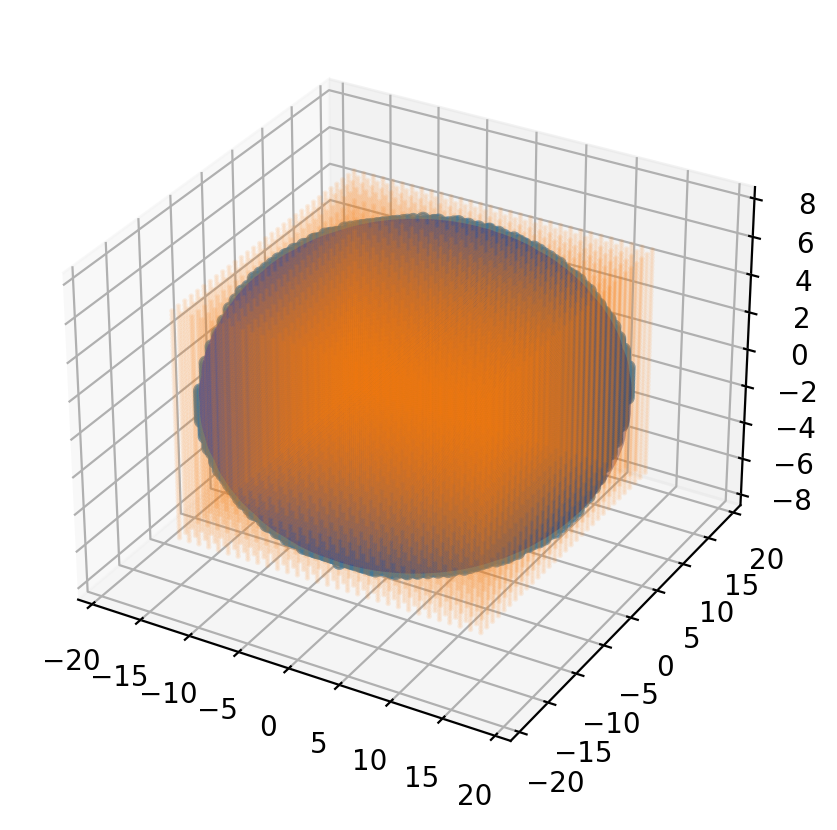

In [ ]:
(x0,x1) = (-0,0)
(y0,y1) = (-0,0)
(z0,z1) = (-6,6)
(Rx0,Rx1) = (-15,15)
(Ry0,Ry1) = (-15,15)
(Rz0,Rz1) = (-0,0)

(xR,yR,zR,RxR,RyR,RzR) = ((x1-x0)/2,(y1-y0)/2,(z1-z0)/2,(Rx1-Rx0)/2,(Ry1-Ry0)/2,(Rz1-Rz0)/2)

res = (0.2,1)

cubic_points = np.mgrid[
    x0:x1:(int((x1-x0)/res[0])+1)*1j,
    y0:y1:(int((y1-y0)/res[0])+1)*1j,
    z0:z1:(int((z1-z0)/res[0])+1)*1j,
    Rx0:Rx1:(int((Rx1-Rx0)/res[1])+1)*1j,
    Ry0:Ry1:(int((Ry1-Ry0)/res[1])+1)*1j,
    Rz0:Rz1:(int((Rz1-Rz0)/res[1])+1)*1j].reshape(6,-1,order='F').T

print(cubic_points.shape)

# print(c_points_normed)

semi_axes_0 = np.ones(6) * 0.8
axes_radii = np.array((xR,yR,zR,RxR,RyR,RzR))
axes_radii[(axes_radii == 0)] = 1
print(axes_radii)

semi_axes = semi_axes_0 / axes_radii

# print(cubic_points[:,0])
radii = ((semi_axes[0]*cubic_points[:,0])**2 + 
        (semi_axes[1]*cubic_points[:,1])**2 + 
        (semi_axes[2]*cubic_points[:,2])**2 + 
        (semi_axes[3]*cubic_points[:,3])**2 + 
        (semi_axes[4]*cubic_points[:,4])**2 +
        (semi_axes[5]*cubic_points[:,5])**2)**0.5

# print(radii)

mask = radii <= 1
# print(mask)

# ellipsoid_points = cubic_points[np.where(mask)]
ellipsoid_points = cubic_points[mask]
print(ellipsoid_points.shape)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

ax.scatter(ellipsoid_points[:,3],ellipsoid_points[:,4],ellipsoid_points[:,2],c='C0',alpha=0.7)
ax.scatter(cubic_points[:,3],cubic_points[:,4],cubic_points[:,2],s=1,c='C1',alpha=0.1)


# coefs = (1/25, 1/25, 1/25)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
# Radii corresponding to the coefficients:
rx, ry, rz = RxR/0.8,RyR/0.8,zR/0.8

# Set of all spherical angles:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

# Plot:
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b', alpha= 0.2)

In [ ]:
# with np.printoptions(threshold=np.inf):
#     print(cubic_points)

cubic_points = np.mgrid[
    x0:x1:(int((x1-x0)/res[0])+1)*1j,
    y0:y1:(int((y1-y0)/res[0])+1)*1j,
    z0:z1:(int((z1-z0)/res[0])+1)*1j,
    Rx0:Rx1:(int((Rx1-Rx0)/res[1])+1)*1j,
    Ry0:Ry1:(int((Ry1-Ry0)/res[1])+1)*1j,
    Rz0:Rz1:(int((Rz1-Rz0)/res[1])+1)*1j].reshape(6,-1,order='F').T


cubic_points.shape

(216, 6)

### Homework from Vanya
 - +/- 200 micrometers
 - +/- 10 degrees
 - +/- 1 mm by hand
 - +/- 3 mm total range of the image

